**Métodos de Previsão Aplicados @ MADSAD - CBS|ISCAC (2022/2023)**

**Trabalho - Parte 2 (40%)**

*Entregáveis:* 
1. este *notebook* resolvido (com **código e comentários** para cada uma das tarefas de 1 a 7)

*Submissão* até **25/04/2023 às 23:59** no InforEstudante

Grupo #:
* Luís Coimbra #2018073846
* Mário Simão #2022120561

# _1. Dados

* *city:* Munich
* *station:* Kreuther
* *ficheiro:* `data_2019-01-01T00_00_00-2022-01-31T23_45_00_Kreuther.csv`

*Fonte:* [Open Bicycle’s Data](https://www.bicycle-data.de/bicycles-data/)

Nesta secção do *notebook* não há tarefas a realizar. Serve apenas para familiarização com o novo conjunto de dados.

Com esse objetivo, são já disponibilizadas as linhas de comandos que é necessário executar, não sendo, no entanto, acompanhadas por comentários aos *outputs* obtidos.

**IMPORTANTE:** Verificar o `file_path` (na segunda célula de código) que tem a localização do ficheiro de dados e, se necessário, corrigir.

## 1.1. Importação e correção do conjunto de dados (incluindo formatos)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/MyDrive/MADSAD/MPA/Trabalho/data_2019-01-01T00_00_00-2022-01-31T23_45_00_Kreuther.csv'

In [4]:
import random
import pandas as pd
import numpy as np
from datetime import timedelta
import math as mt
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

In [5]:
df_raw = pd.read_csv(file_path)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107798 entries, 0 to 107797
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   start           107798 non-null  object
 1   end             107798 non-null  object
 2   bothDirections  107798 non-null  int64 
 3   classification  107798 non-null  object
 4   station         107798 non-null  object
dtypes: int64(1), object(4)
memory usage: 4.1+ MB


In [6]:
df_raw.start.nunique()

107798

In [7]:
df_raw.head()

start                  end  bothDirections classification  \
0  2019-01-01 00:00:00  2019-01-01 00:15:00               0           Cold   
1  2019-01-01 00:15:00  2019-01-01 00:30:00               0     Heavy rain   
2  2019-01-01 00:30:00  2019-01-01 00:45:00               0           Cold   
3  2019-01-01 00:45:00  2019-01-01 01:00:00               0           Cold   
4  2019-01-01 01:00:00  2019-01-01 01:15:00               0     Light rain   

    station  
0  Kreuther  
1  Kreuther  
2  Kreuther  
3  Kreuther  
4  Kreuther

In [8]:
df = (df_raw
      .filter(['start','bothDirections','classification'])
      .assign(start = pd.to_datetime(df_raw.start))
      .set_index('start')
      .asfreq('15min')
)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108192 entries, 2019-01-01 00:00:00 to 2022-01-31 23:45:00
Freq: 15T
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   bothDirections  107798 non-null  float64
 1   classification  107798 non-null  object 
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [9]:
df.head()

bothDirections classification
start                                             
2019-01-01 00:00:00             0.0           Cold
2019-01-01 00:15:00             0.0     Heavy rain
2019-01-01 00:30:00             0.0           Cold
2019-01-01 00:45:00             0.0           Cold
2019-01-01 01:00:00             0.0     Light rain

In [10]:
df.tail()

bothDirections classification
start                                             
2022-01-31 22:45:00             1.0         Stormy
2022-01-31 23:00:00             0.0          Windy
2022-01-31 23:15:00             0.0     Light rain
2022-01-31 23:30:00             0.0           Cold
2022-01-31 23:45:00             0.0           Cold

## 1.2. Análise descritiva rápida

In [11]:
df.reset_index().describe(include='all', datetime_is_numeric=False).round(2)

<ipython-input-11-8cf1c2cf6bd1>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.reset_index().describe(include='all', datetime_is_numeric=False).round(2)


start  bothDirections classification
count                108192       107798.00         107798
unique               108192             NaN             15
top     2019-01-01 00:00:00             NaN           Cold
freq                      1             NaN          50108
first   2019-01-01 00:00:00             NaN            NaN
last    2022-01-31 23:45:00             NaN            NaN
mean                    NaN            5.56            NaN
std                     NaN            8.00            NaN
min                     NaN            0.00            NaN
25%                     NaN            0.00            NaN
50%                     NaN            2.00            NaN
75%                     NaN            8.00            NaN
max                     NaN           92.00            NaN

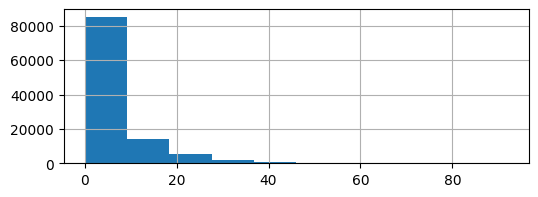

In [12]:
df.bothDirections.hist(figsize=(6,2));

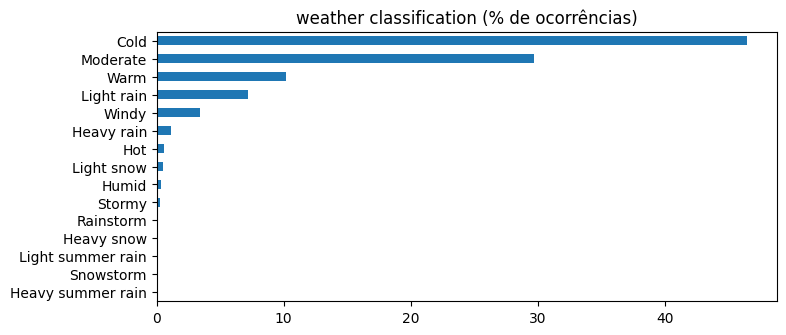

In [13]:

(df
 .classification
 .value_counts(normalize=True)
 .sort_values(ascending=True)
 .mul(100)
 .plot
 .barh(figsize=(8,3.5), title='weather classification (% de ocorrências)')
);

## 1.3. Timestamps em falta

In [14]:
len(df)-len(df.query('not bothDirections.isna()'))

394

In [15]:
pd.Series(df.query('bothDirections.isna()').index.date).value_counts()

2019-06-01    96
2019-06-02    96
2019-06-03    96
2019-06-04    96
2020-04-09     5
2020-03-29     4
2019-03-31     1
dtype: int64

In [16]:
df.query('"2019-03-31 01:00:00" <= index < "2019-03-31 04:00:00"')

bothDirections classification
start                                             
2019-03-31 01:00:00             0.0           Cold
2019-03-31 01:15:00             1.0           Cold
2019-03-31 01:30:00             0.0           Cold
2019-03-31 01:45:00             1.0           Cold
2019-03-31 02:00:00             0.0           Cold
2019-03-31 02:15:00             0.0           Cold
2019-03-31 02:30:00             NaN            NaN
2019-03-31 02:45:00             0.0           Cold
2019-03-31 03:00:00             0.0           Cold
2019-03-31 03:15:00             0.0           Cold
2019-03-31 03:30:00             0.0           Cold
2019-03-31 03:45:00             0.0           Cold

In [17]:
df.query('"2020-03-29 01:00:00" <= index < "2020-03-29 04:00:00"')

bothDirections classification
start                                             
2020-03-29 01:00:00             0.0           Cold
2020-03-29 01:15:00             0.0           Cold
2020-03-29 01:30:00             0.0           Cold
2020-03-29 01:45:00             0.0           Cold
2020-03-29 02:00:00             NaN            NaN
2020-03-29 02:15:00             NaN            NaN
2020-03-29 02:30:00             NaN            NaN
2020-03-29 02:45:00             NaN            NaN
2020-03-29 03:00:00             0.0           Cold
2020-03-29 03:15:00             0.0           Cold
2020-03-29 03:30:00             0.0           Cold
2020-03-29 03:45:00             0.0           Cold

In [18]:
df.query('"2020-04-09 13:00:00" <= index < "2020-04-09 16:00:00"')

bothDirections classification
start                                             
2020-04-09 13:00:00             6.0       Moderate
2020-04-09 13:15:00            19.0           Warm
2020-04-09 13:30:00            13.0           Warm
2020-04-09 13:45:00            22.0           Warm
2020-04-09 14:00:00             NaN            NaN
2020-04-09 14:15:00             NaN            NaN
2020-04-09 14:30:00             NaN            NaN
2020-04-09 14:45:00             NaN            NaN
2020-04-09 15:00:00             NaN            NaN
2020-04-09 15:15:00            18.0           Warm
2020-04-09 15:30:00            18.0           Warm
2020-04-09 15:45:00            15.0           Warm

In [19]:
df.query('index=="2020-04-09"').index.day_name()

Index(['Thursday'], dtype='object', name='start')

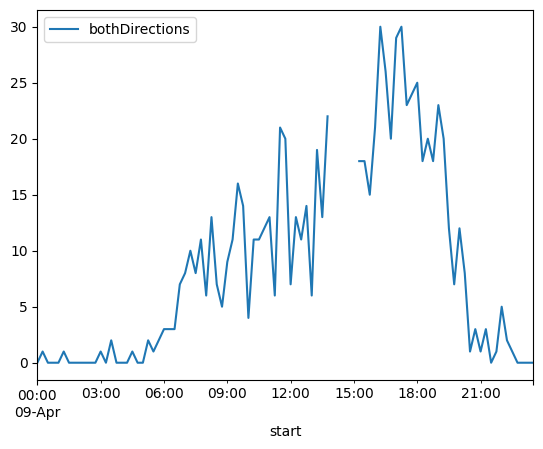

In [20]:
df.query('"2020-04-09 00:00:00" <= index < "2020-04-09 23:45:00"').plot();

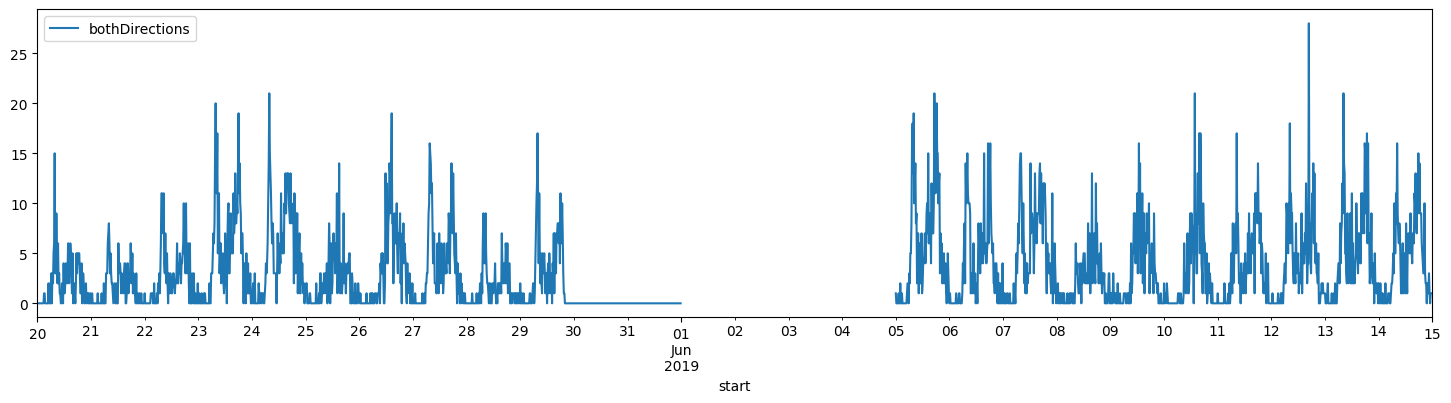

In [21]:
df.query('"2019-05-20" <= index <= "2019-06-15"').plot(figsize=(18,4));

In [22]:
df.query('"2019-05-29 19:00:00" <= index < "2019-05-29 23:00:00"')

bothDirections classification
start                                             
2019-05-29 19:00:00             7.0       Moderate
2019-05-29 19:15:00             3.0       Moderate
2019-05-29 19:30:00             1.0       Moderate
2019-05-29 19:45:00             1.0     Light rain
2019-05-29 20:00:00             0.0     Light rain
2019-05-29 20:15:00             0.0       Moderate
2019-05-29 20:30:00             0.0       Moderate
2019-05-29 20:45:00             0.0       Moderate
2019-05-29 21:00:00             0.0       Moderate
2019-05-29 21:15:00             0.0       Moderate
2019-05-29 21:30:00             0.0       Moderate
2019-05-29 21:45:00             0.0       Moderate
2019-05-29 22:00:00             0.0       Moderate
2019-05-29 22:15:00             0.0       Moderate
2019-05-29 22:30:00             0.0       Moderate
2019-05-29 22:45:00             0.0       Moderate

In [23]:
df.query('"2019-05-31 23:00:00" <= index < "2019-06-01 01:00:00"')

bothDirections classification
start                                             
2019-05-31 23:00:00             0.0       Moderate
2019-05-31 23:15:00             0.0       Moderate
2019-05-31 23:30:00             0.0       Moderate
2019-05-31 23:45:00             0.0       Moderate
2019-06-01 00:00:00             NaN            NaN
2019-06-01 00:15:00             NaN            NaN
2019-06-01 00:30:00             NaN            NaN
2019-06-01 00:45:00             NaN            NaN

In [24]:
df.query('"2019-06-04 23:00:00" <= index < "2019-06-05 01:00:00"')

bothDirections classification
start                                             
2019-06-04 23:00:00             NaN            NaN
2019-06-04 23:15:00             NaN            NaN
2019-06-04 23:30:00             NaN            NaN
2019-06-04 23:45:00             NaN            NaN
2019-06-05 00:00:00             1.0       Moderate
2019-06-05 00:15:00             0.0       Moderate
2019-06-05 00:30:00             0.0       Moderate
2019-06-05 00:45:00             0.0       Moderate

# _2. Imputar dados em falta

> **Tarefa 1:** Fazer a imputação dos registos em falta. Segue-se uma sugestão para fazer esta imputação. Caso a sugestão seja seguida, deve ser comentada/criticada. Caso contrário, a abordagem alternativa deve ser justificada.

Atendendo à análise feita na secção anterior pode-se dizer que há três grupos de dados em falta:
* **G1**: nos dias `2019-03-31` e `2020-03-29` - dias de anos diferentes, mas ambos do mês de março; dados em falta de madrugada e em quantidade reduzida. </br> ***Sugestão:*** Preencher `bothDirections` com zeros e `classification` com `'Cold'`.
* **G2**: no dia `2020-04-09` - cinco timestamps seguidos em falta entre as 14:00 e as 15:00 de uma quinta-feira de abril. </br> ***Sugestão:*** Preencher `bothDirections` por interpolação linear (que é opção por omissão em [pandas.DataFrame.interpolate](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html)) e depois garantir que o valor imputado é um inteiro e `classification` com `'Warm'`.
* **G3**: entre os *timestamps* `2019-05-29 20:00:00` e `2019-06-04 23:45:00` - pouco mais de seis dias seguidos em que se percebe que há problemas; começando um pouco antes dos dois últimos dias de maio, os registos são sempre iguais a zero; e, nos quatro primeiros dias de junho, os dados estão em falta. </br> ***Sugestão:*** Preencher `bothDirections`, entre `2019-05-29 20:00:00` e `2019-06-04 23:45:00`, com a média de dois registos da mesma variável, concretamente, os dois registos que têm o mesmo *time* e dia da semana do registo em falta, sendo um da semana anterior e o outro da semana seguinte à falta, e depois garantir que o valor imputado é um inteiro. Preencher `classification`, entre `2019-06-01 00:00:00` e `2019-06-04 23:45:00`, usando o mesmo princípio usado para a variável `bothDirections`, mas, em vez da média, fazer uma escolha aleatória entre os dois registos. </br> *O exemplo seguinte serve para ilustar a sugestão para G3.*

**Antes da imputação de valores**

| timestamp           | day of the week | bothDirections | classification |
|:-------------------:|:---------------:|:--------------:|:--------------:|
| 2019-05-25 13:00:00 | Saturday        | 5              | Warm           |
| 2019-05-25 13:15:00 | Saturday        | 3              | Warm           |
| 2019-05-25 13:30:00 | Saturday        | 6              | Warm           |
| 2019-05-25 13:45:00 | Saturday        | 5              | Warm           |
| …                   |                 |                |                |
| 2019-06-01 13:00:00 | Saturday        | NaN            | NaN            |
| 2019-06-01 13:15:00 | Saturday        | NaN            | NaN            |
| 2019-06-01 13:30:00 | Saturday        | NaN            | NaN            |
| 2019-06-01 13:45:00 | Saturday        | NaN            | NaN            |
| …                   |                 |                |                |
| 2019-06-08 13:00:00 | Saturday        | 3              | Moderate       |
| 2019-06-08 13:15:00 | Saturday        | 2              | Moderate       |
| 2019-06-08 13:30:00 | Saturday        | 2              | Moderate       |
| 2019-06-08 13:45:00 | Saturday        | 2              | Warm           |

**Depois da imputação de valores**

| timestamp           | day of the week | bothDirections | classification |
|:-------------------:|:---------------:|:--------------:|:--------------:|
| 2019-05-25 13:00:00 | Saturday        | 5              | Warm           |
| 2019-05-25 13:15:00 | Saturday        | 3              | Warm           |
| 2019-05-25 13:30:00 | Saturday        | 6              | Warm           |
| 2019-05-25 13:45:00 | Saturday        | 5              | Warm           |
| …                   |                 |                |                |
| 2019-06-01 13:00:00 | Saturday        | 4              | Warm           |
| 2019-06-01 13:15:00 | Saturday        | 3              | Moderate       |
| 2019-06-01 13:30:00 | Saturday        | 4              | Warm           |
| 2019-06-01 13:45:00 | Saturday        | 4              | Warm           |
| …                   |                 |                |                |
| 2019-06-08 13:00:00 | Saturday        | 3              | Moderate       |
| 2019-06-08 13:15:00 | Saturday        | 2              | Moderate       |
| 2019-06-08 13:30:00 | Saturday        | 2              | Moderate       |
| 2019-06-08 13:45:00 | Saturday        | 2              | Warm           |



## **Sugestão de Realização G1**


Substituição dos valores em falta do primeiro período de tempo

In [25]:
df.loc['2019-03-31 01:00:00':'2019-03-31 04:00:00', 'bothDirections'] = df.loc['2019-03-31 01:00:00':'2019-03-31 04:00:00', 'bothDirections'].fillna(0)
df.loc['2019-03-31 01:00:00':'2019-03-31 04:00:00', 'classification'] = df.loc['2019-03-31 01:00:00':'2019-03-31 04:00:00', 'classification'].fillna('Cold')

De seguida verifica-se se este método resultou:

In [26]:
df['2019-03-31 01:00:00':'2019-03-31 04:00:00']

bothDirections classification
start                                             
2019-03-31 01:00:00             0.0           Cold
2019-03-31 01:15:00             1.0           Cold
2019-03-31 01:30:00             0.0           Cold
2019-03-31 01:45:00             1.0           Cold
2019-03-31 02:00:00             0.0           Cold
2019-03-31 02:15:00             0.0           Cold
2019-03-31 02:30:00             0.0           Cold
2019-03-31 02:45:00             0.0           Cold
2019-03-31 03:00:00             0.0           Cold
2019-03-31 03:15:00             0.0           Cold
2019-03-31 03:30:00             0.0           Cold
2019-03-31 03:45:00             0.0           Cold
2019-03-31 04:00:00             0.0           Cold

Repetem-se os mesmos passos para o segundo período de tempo em questão:

In [27]:
df.loc['2020-03-29 01:00:00':'2020-03-29 04:00:00', 'bothDirections'] = df.loc['2020-03-29 01:00:00':'2020-03-29 04:00:00', 'bothDirections'].fillna(0)
df.loc['2020-03-29 01:00:00':'2020-03-29 04:00:00', 'classification'] = df.loc['2020-03-29 01:00:00':'2020-03-29 04:00:00', 'classification'].fillna('Cold')

In [28]:
df['2020-03-29 01:00:00':'2020-03-29 04:00:00']

bothDirections classification
start                                             
2020-03-29 01:00:00             0.0           Cold
2020-03-29 01:15:00             0.0           Cold
2020-03-29 01:30:00             0.0           Cold
2020-03-29 01:45:00             0.0           Cold
2020-03-29 02:00:00             0.0           Cold
2020-03-29 02:15:00             0.0           Cold
2020-03-29 02:30:00             0.0           Cold
2020-03-29 02:45:00             0.0           Cold
2020-03-29 03:00:00             0.0           Cold
2020-03-29 03:15:00             0.0           Cold
2020-03-29 03:30:00             0.0           Cold
2020-03-29 03:45:00             0.0           Cold
2020-03-29 04:00:00             0.0           Cold

**Este método de substituir os valores numéricos por 0 e de atribuir 'Cold' a todas as observações em falta, nestes 2 casos em específico, é muito pertinente. Como se pode observar no restante período de tempo em que não existem dados em falta, todas as observações apresentavam a 'Classification' como 'Cold', e praticamente todos os valores da coluna bothDirections eram 0. Também podemos ter em conta as horas que estamos a analisar - madrugada - e entender que é natural não haverem passagens e estar uma temperatura fria. É uma escolha racional e justificável proceder a esta substituição neste caso.**

## **Sugestão de Realização G2**

In [29]:
df.loc['2020-04-09 13:45:00':'2020-04-09 15:15:00', 'bothDirections'] = df.loc['2020-04-09 13:45:00':'2020-04-09 15:15:00', 'bothDirections'].interpolate().round()
df.loc['2020-04-09 13:45:00':'2020-04-09 15:15:00', 'classification'] = df.loc['2020-04-09 13:45:00':'2020-04-09 15:15:00', 'classification'].fillna('Warm')

In [30]:
df['2020-04-09 13:45:00':'2020-04-09 15:15:00']

bothDirections classification
start                                             
2020-04-09 13:45:00            22.0           Warm
2020-04-09 14:00:00            21.0           Warm
2020-04-09 14:15:00            21.0           Warm
2020-04-09 14:30:00            20.0           Warm
2020-04-09 14:45:00            19.0           Warm
2020-04-09 15:00:00            19.0           Warm
2020-04-09 15:15:00            18.0           Warm

**A interpolação linear é um método para estimar valores intermédios entre dois pontos de dados conhecidos. Neste caso, não podemos proceder à substituição dos valores em falta como fizémos anteriormente, utilizando um valor fixo, dada as distintas contagens que temos nesta ocasião. Este método mostra-se útil neste caso específico. A substituição dos valores em falta na coluna 'Classification' fez-se mais uma vez, pelo valor mais recorrente durante este período de tempo.**

## **Sugestão de Realização G3**

In [31]:
missing_data = df.loc['2019-05-29 20:00:00':'2019-06-04 23:45:00']

for index, row in missing_data.iterrows():
    one_week_ago = index - pd.Timedelta(weeks=1) #Para se obter a data de exatamente uma semana anterior a cada observação
    one_week_later = index + pd.Timedelta(weeks=1) #Para se obter a data de extamente uma semana seguinte a cada observação

  #Este próximo passo pretende atribuir uma série de condições aos dados a serem utilizados para se calcularem os valores em falta, 
  #Primeiro certificam-se que estes valores não estão também em falta, depois que o dia da semana do index corresponda ao dia da semana da nova variável
  #E por fim que o index esteja exatamente 1 semana atrás ou à frente da variável
    valid_data = df.loc[(df.bothDirections.notna()) & (df.index.weekday == index.weekday()) &
                             ((df.index == one_week_ago) | (df.index == one_week_later))]
    
    new_value = mt.ceil(valid_data.bothDirections.mean()) #Criam-se os novos valores resultantes do for anterior
    
    df.loc[index, 'bothDirections'] = new_value #Atribuem-se estes valores à coluna bothDirections


Utilizando a mesma estrutura para obter os valores da coluna bothDirections, apresenta-se o mesmo processo para a coluna Classification:

In [32]:
missing_dt = df.loc['2019-06-01 00:00:00':'2019-06-04 23:45:00']

for index, row in missing_dt.iterrows():
    one_week_ago = index - pd.Timedelta(weeks=1) 
    one_week_later = index + pd.Timedelta(weeks=1) 
    

    valid_dt = df.loc[(df.classification.notna()) & (df.index.weekday == index.weekday()) &
                        ((df.index == one_week_ago) | (df.index == one_week_later))]
    
    if len(valid_dt) > 0:
        random_value = random.choice(valid_dt.classification.values)
        df.at[index, 'classification'] = random_value

Pretende-se saber se o processo resultou, para isso apresenta-se os novos registos de dia 2019-06-02, que anteriormente se encontrava sem registos, como se pode ver no gráfico do ponto 1, e observa-se agora que se encontra completo com novos valores:

In [33]:
df.query('"2019-06-01 13:00:00" <= index < "2019-06-01 14:00:00"')

bothDirections classification
start                                             
2019-06-01 13:00:00             4.0           Warm
2019-06-01 13:15:00             3.0       Moderate
2019-06-01 13:30:00             4.0       Moderate
2019-06-01 13:45:00             4.0           Warm

Como se pode observar pelos resultados acima, este método funcionou - os valores da coluna classification estão aleatoriamente distribuídos entre 'warm' e 'moderate' e os valores da coluna 'bothDirections apresentam a média entre os valores sugeridos.

**É um método bastante complexo para a substituição de valores em falta, que por sua vez apresenta resultados únicos. Ao termos praticamente 1 semana em falta, surge a necessidade de um método mais avançado de substituição de dados, daí a sua utilização.**

# _3. Série temporal a estudar

> **Tarefa 2:** Definir a série temporal a analisar que é a série das contagens com periodicidade **diária**. Esta é a série a considerar nas tarefas 3 a 6.

In [34]:
daily = df.resample('D').agg({'bothDirections': 'sum', 'classification': 'last'})

In [35]:
daily.query('"2019-05-26" <= index < "2019-05-28"')

bothDirections classification
start                                    
2019-05-26           325.0       Moderate
2019-05-27           345.0     Light rain

Aqui muda-se a frequência dos dados para diária. Os valores que estavam na coluna 'bothDirections' são somados, e os valores na coluna Classification ficam com o último valor registado nesse dia.
**Nota - Utilizando este método na coluna 'classification' significa que os dados desta assumam o valor registado às 23:45:00 de todos os dias, podendo haver então um maior número de registos de tempos mais frios, caraterísticos deste horário**

# _4. Identificar as componentes da série

> **Tarefa 3:** Obter os gráficos necessários (incluindo o correlograma, mas excluindo a decomposição) para permitir a identificação das componentes da série e comentar.

Começa-se por se fragmentar em 4 partes este novo dataframe diário, cada parte corresponde a um dos anos em questão. **Esta divisão vai facilitar a identificação dos componentes da série**

In [36]:
daily2019 = daily.loc[daily.index.year==2019]
daily2020 = daily.loc[daily.index.year==2020]
daily2021 = daily.loc[daily.index.year==2021]
daily2022 = daily.loc[daily.index.year==2022]


Só pela análise do gráfico gerado, nota-se claramente que existe uma queda abrupta na utilização de bicicletas nos meses mais frios do ano (Inverno), possivelmente devido à temperatura, chuva e condições da via. Em contraste ao que já foi averiguado, existe a presença de uma maior utilização também para os meses de maior calor, existindo um maior pico nos meses de Junho a Setembro 

In [37]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=daily2019.index, y=daily2019['bothDirections'], name='2019', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=daily2020.index, y=daily2020['bothDirections'], name='2020', line=dict(color='red')))
fig.add_trace(go.Scatter(x=daily2021.index, y=daily2021['bothDirections'], name='2021', line=dict(color='green')))
fig.add_trace(go.Scatter(x=daily2022.index, y=daily2022['bothDirections'], name='2022', line=dict(color='purple')))

fig.update_layout(title='Número de passageiros por ano',
                  xaxis=dict(title='Data'),
                  yaxis=dict(title='Número de passageiros'))

fig.show()


**Reconhece-se que existe uma Sazonalidade anual neste conjunto de dados. Os primeiros meses do ano apresentam um número mais reduzido de passagens, que começam a subir gradualmente, até atingirem o seu pico em junho que se mantém até setembro, a partir daí volta a decrescer gradualmente até atingir o seu ponto mais baixo entre o final de dezembro e início de janeiro do ano seguinte, onde este padrão se repete**

De seguida, cria-se um autocorrelograma, outra visualização que nos permite averiguar a sazonalidade de uma série, utilizando a relação de uma variável entre si ao longo do tempo. Lags referem-se ao intervalo de tempo entre um valor de uma série temporal e outro valor subsequente na mesma série.Nesta caso o primeiro valor será janeiro de 2019, o segundo fevereiro de 2019... e 1 lag representa as diferenças entre as passagens de janeiro e fevereiro:

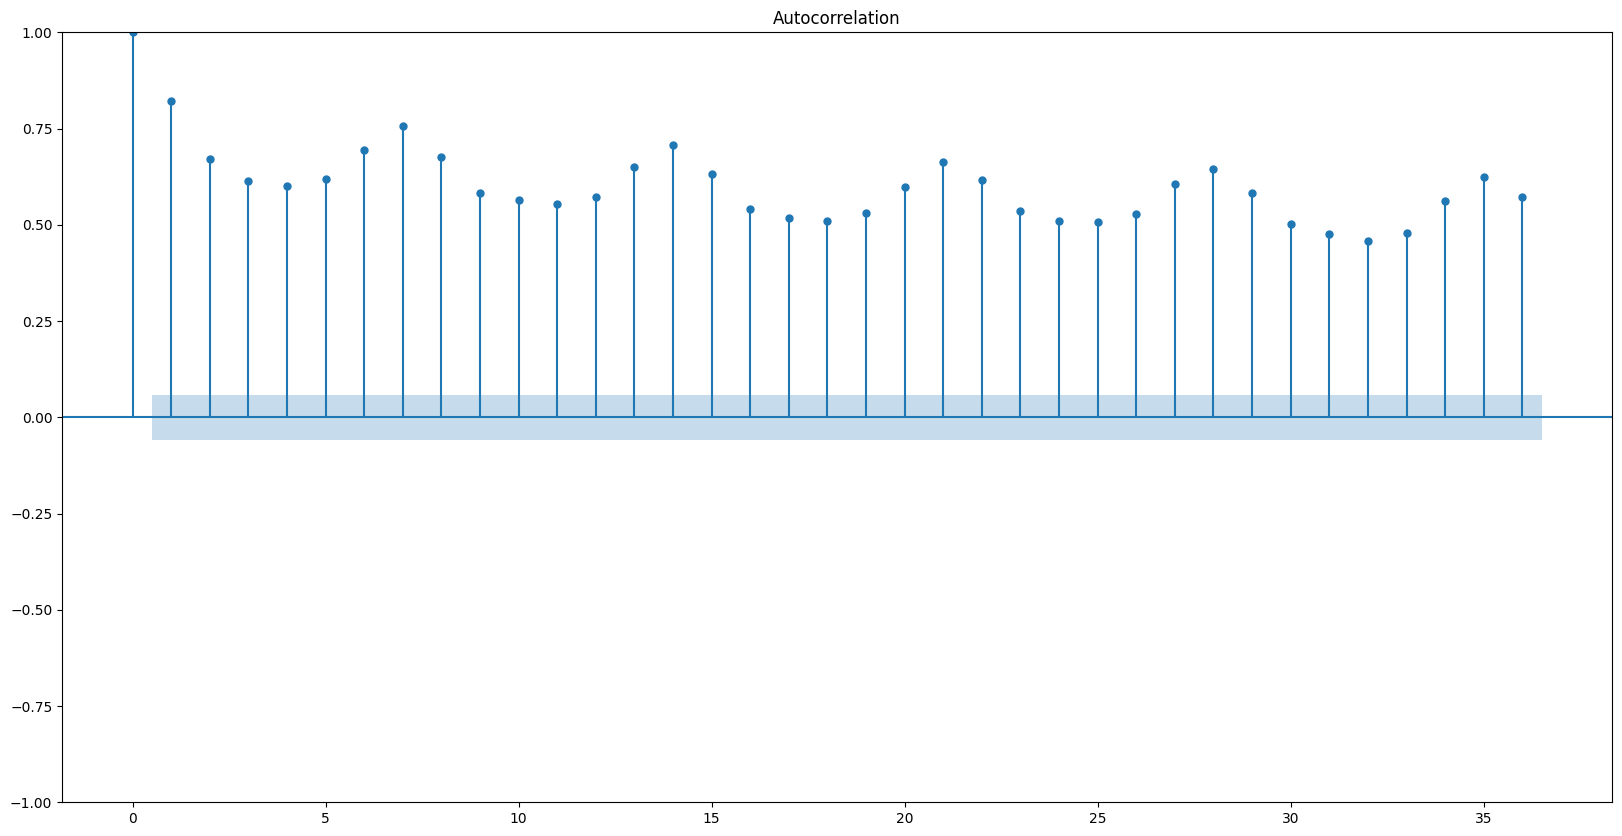

In [38]:
acf = sm.graphics.tsa.plot_acf(daily["bothDirections"], lags=36, bartlett_confint=False) #Escolheu-se este número de lags porque corresponde ao número total de meses
acf.set_size_inches((20,10))

Também se pode observar um gráfico das passagens diárias, que mostre esta sazonalidade semanal encontrada:

<Axes: title={'center': 'Número de passagens diárias'}, xlabel='start'>

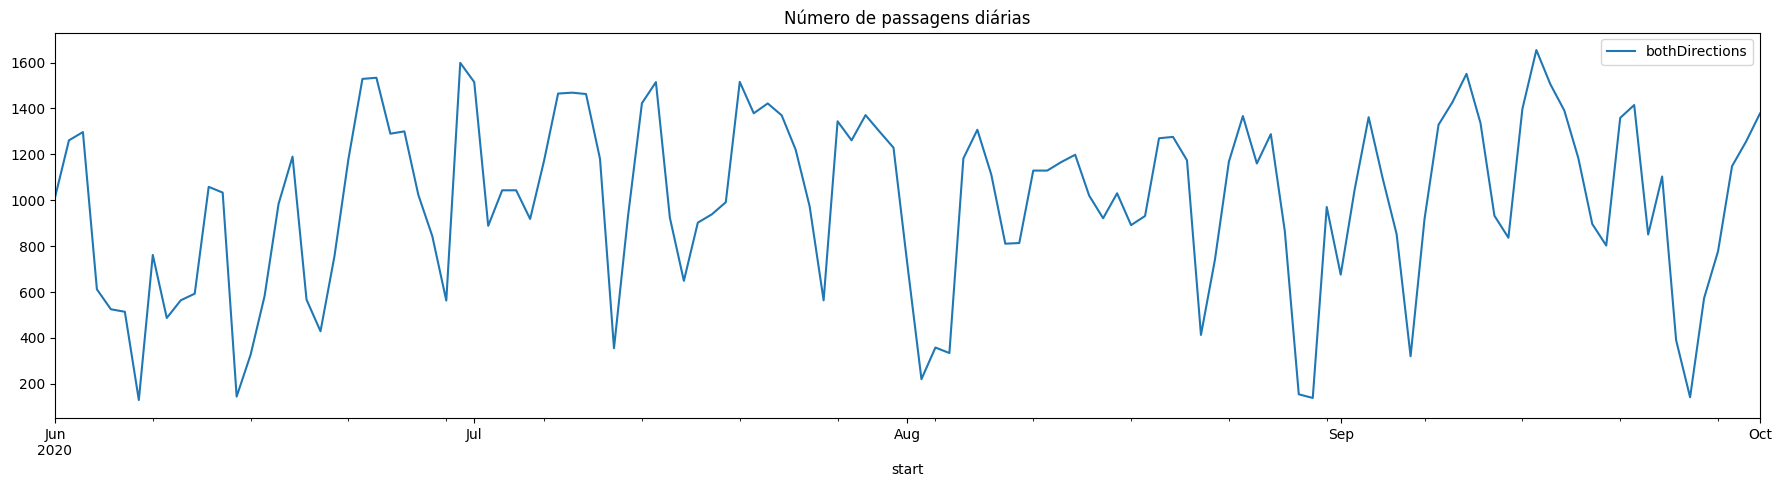

In [39]:
daily['2020-06-01':'2020-10-01'].plot(figsize=(22,5),title="Número de passagens diárias")

**Após a análise desta visualização, fica claro que existe também uma sazonalidade semanal! Os períodos de 7 dias apresentados demonstram um padrão distinto que pode ser explicado pela utilização de bicicletas pelos diferentes dias da semana, findos os 7 dias este padrão volta-se a repetir confirmasno então que se trata de sazonalidade semanal**

Neste próximo exemplo pretende-se construir um gráfico que nos permita entender se existe uma tendência no nosso conjunto de dados. Cria-se uma cópia do nosso dataframe diário, e adicionam-se as colunas do mês e do ano para ser mais fácil construir o gráfico e procede-se à sua análise.


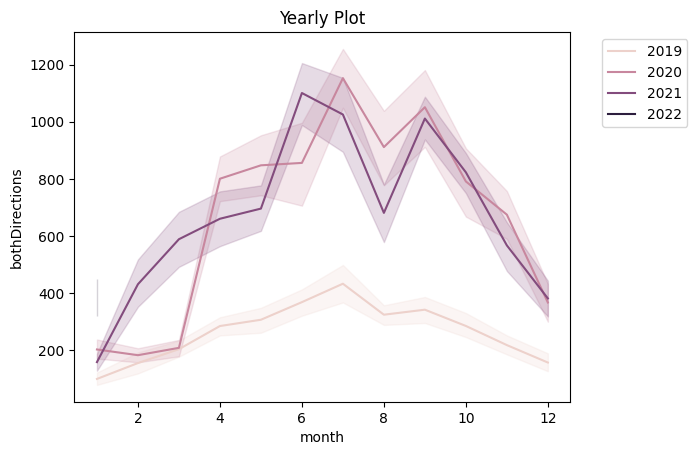

In [40]:
dailygraph = daily
dailygraph['month'] = dailygraph.index.month
dailygraph['year'] = dailygraph.index.year


sns.lineplot(data=dailygraph, x = 'month', y='bothDirections', hue = 'year', legend = 'full')
plt.title('Yearly Plot')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

daily.drop(['year', 'month'], axis=1, inplace=True)



Também pode ser útil a criação de um gráfico de médias móveis, visto que esta é uma técnica descritiva simples para suavizar uma série e fazer emergir a tendência.

In [41]:
mms = (daily
       .assign(mms_standard = daily.bothDirections.rolling(7).mean())
       .assign(mms_centrada = daily.bothDirections.rolling(7, center=True).mean())
       )

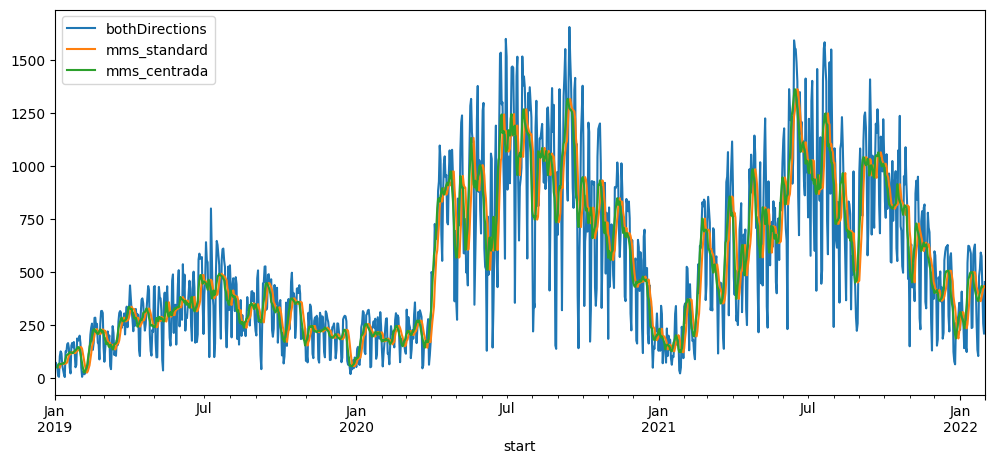

In [42]:
mms.plot(figsize=(12,5));

**Após a análise destes gráficos, nota-se a dificuldade de averiguar se existe uma tendência forte, que se consiga ver a "olho". Há um aumento notável na utilização de bicicletas desde o ano de 2019 para 2020, no entanto de 2020 para 2021, há uma estagnação da componente da tendência, visto que nestas visualizações as contagens destes 2 anos apresentam valores bastantes semelhantes**

# _5. Decompor a série

> **Tarefa 4:** Obter a decomposição da série, considerando a abordagem [clássica](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html#statsmodels.tsa.seasonal.seasonal_decompose) e [STL](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.STL.html#statsmodels.tsa.seasonal.STL), e comentar.

*Observação:* A decomposição STL para sazonalidade múltipla ([MSTL](https://www.statsmodels.org/dev/examples/notebooks/generated/mstl_decomposition.html)) só está disponível na versão 0.14.0 do `statsmodels`. Esta versão não está disponível para instalação `pip`, que tem como versão mais recente a [versão 0.13.5](https://pypi.org/project/statsmodels/#history). Assim, não se pede que MSTL seja usada. No entanto, tal tem consequências na dificuldade de seleção do valor a usar no argumento `period` para as decomposições no `statsmodels` e na qualidade dos resultados obtidos.

*Sugestão:* Experimentar, para o argumento `period`, vários múltiplos de 7 (por exemplo, 7, 28, 42, 56, 168).

### **Decomposição Clássica Aditiva**

A decomposição clássica aditiva consiste num método para decompor uma série temporal em 3 componentes principais : Tendência , sazonalidade e componente residual.
A **tendência** representa a evolução dos dados ao longo do tempo ; a **sazonalidade** representa variações regulares e previsíveis que ocorrem em intervalos fixos de tempo(anual,mensal...) ; e a componente **irregular** , representa as flutuações aleatórias que não podem ser explicadas pelas outras duas componentes.
Esta decomposição é aditiva pois assume que a série temporal é uma soma das 3 componentes anteriores.

De seguida apresenta-se o dataframe criado para demonstrar os valores da decomposição clássica aditiva

In [43]:
decomp_additive = seasonal_decompose(daily["bothDirections"], model='additive')

df_decomp_additive = pd.DataFrame({'observed': decomp_additive.observed,
                                   'trend': decomp_additive.trend,
                                   'seasonal': decomp_additive.seasonal,
                                   'residual': decomp_additive.resid})
df_decomp_additive.head(10)

observed      trend    seasonal    residual
start                                                  
2019-01-01      43.0        NaN   89.623019         NaN
2019-01-02      72.0        NaN   90.083733         NaN
2019-01-03      63.0        NaN   76.589983         NaN
2019-01-04      49.0  49.000000   40.529746  -40.529746
2019-01-05       9.0  60.714286 -153.964481  102.250196
2019-01-06       5.0  67.000000 -186.309124  124.309124
2019-01-07     102.0  66.285714   43.447126   -7.732840
2019-01-08     125.0  64.571429   89.623019  -29.194447
2019-01-09     116.0  65.857143   90.083733  -39.940876
2019-01-10      58.0  65.714286   76.589983  -84.304269

E agora as visualizações desta decomposição

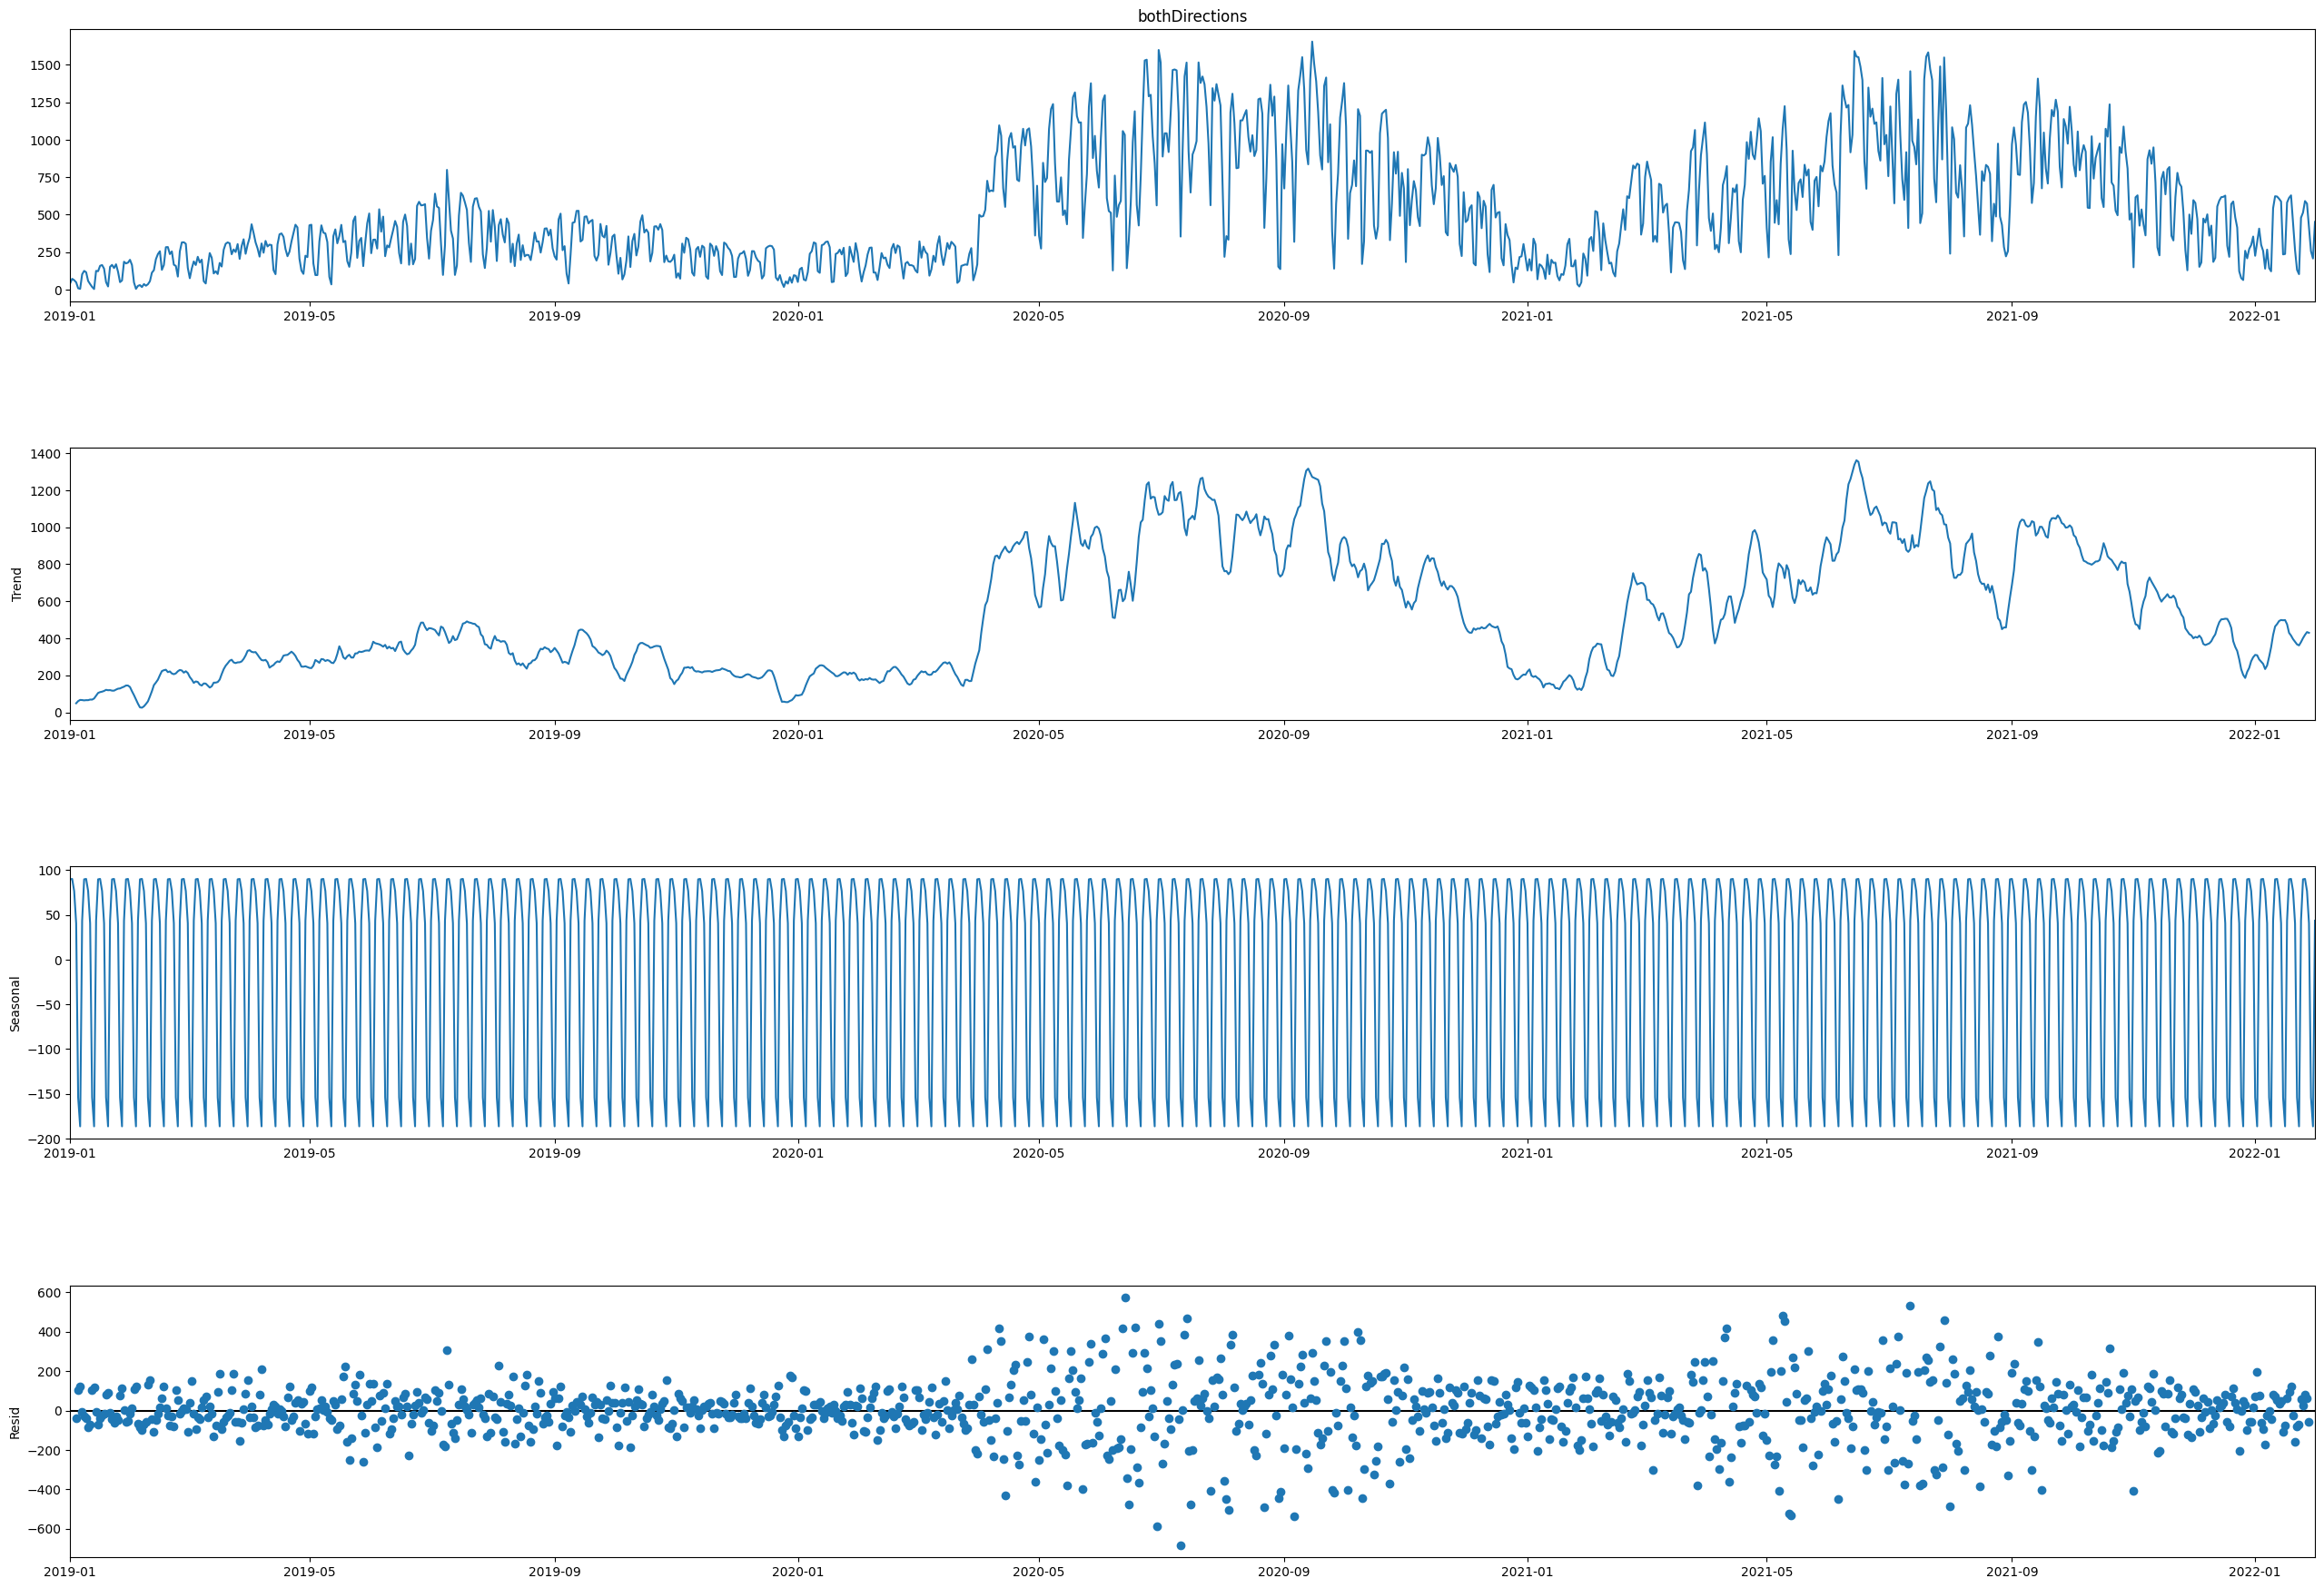

In [44]:
fig = decomp_additive.plot()
fig.set_size_inches((30,20));

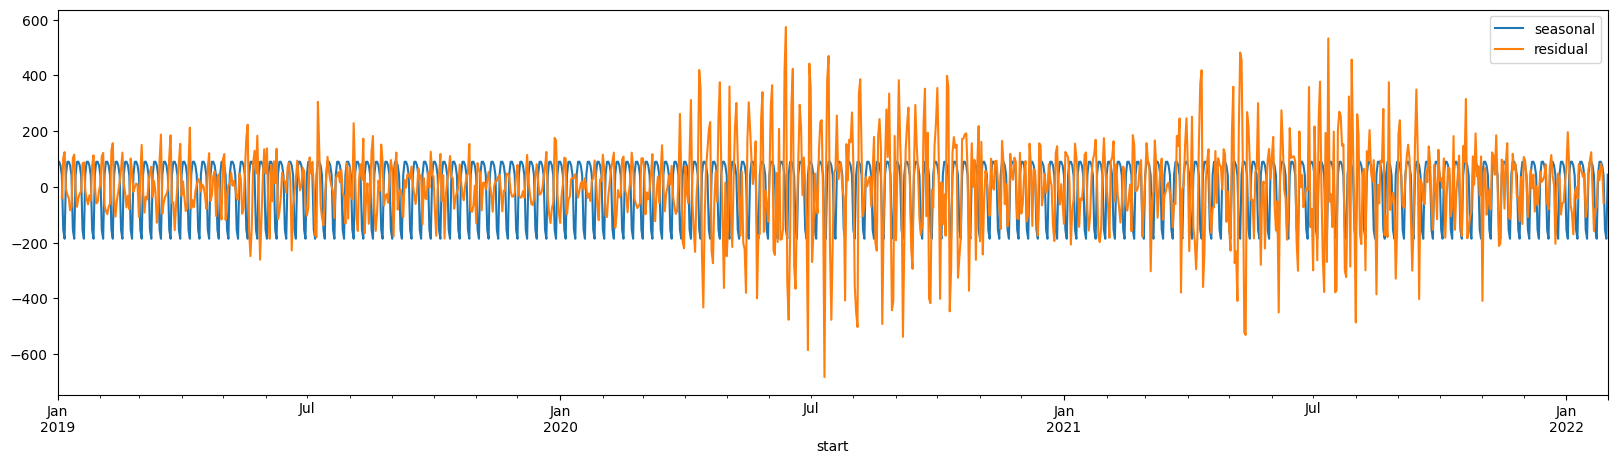

In [45]:
df_decomp_additive.filter(['seasonal','residual']).plot(figsize=(20,5));

**A seguir repete-se o passo anterior com um período de 168:**

In [46]:
decomp_additive2 = seasonal_decompose(daily["bothDirections"], model='additive',period = 168)

df_decomp_additive2 = pd.DataFrame({'observed': decomp_additive2.observed,
                                   'trend': decomp_additive2.trend,
                                   'seasonal': decomp_additive2.seasonal,
                                   'residual': decomp_additive2.resid})
df_decomp_additive2.head(15)

observed  trend    seasonal  residual
start                                            
2019-01-01      43.0    NaN   82.732172       NaN
2019-01-02      72.0    NaN  137.579890       NaN
2019-01-03      63.0    NaN  102.043680       NaN
2019-01-04      49.0    NaN  130.031279       NaN
2019-01-05       9.0    NaN -158.137868       NaN
2019-01-06       5.0    NaN -123.807015       NaN
2019-01-07     102.0    NaN  169.653799       NaN
2019-01-08     125.0    NaN  225.691497       NaN
2019-01-09     116.0    NaN  252.152311       NaN
2019-01-10      58.0    NaN  133.965307       NaN
2019-01-11      37.0    NaN  163.222747       NaN
2019-01-12      18.0    NaN  -91.735586       NaN
2019-01-13       4.0    NaN -193.938959       NaN
2019-01-14     125.0    NaN  133.505981       NaN
2019-01-15     123.0    NaN  262.877509       NaN

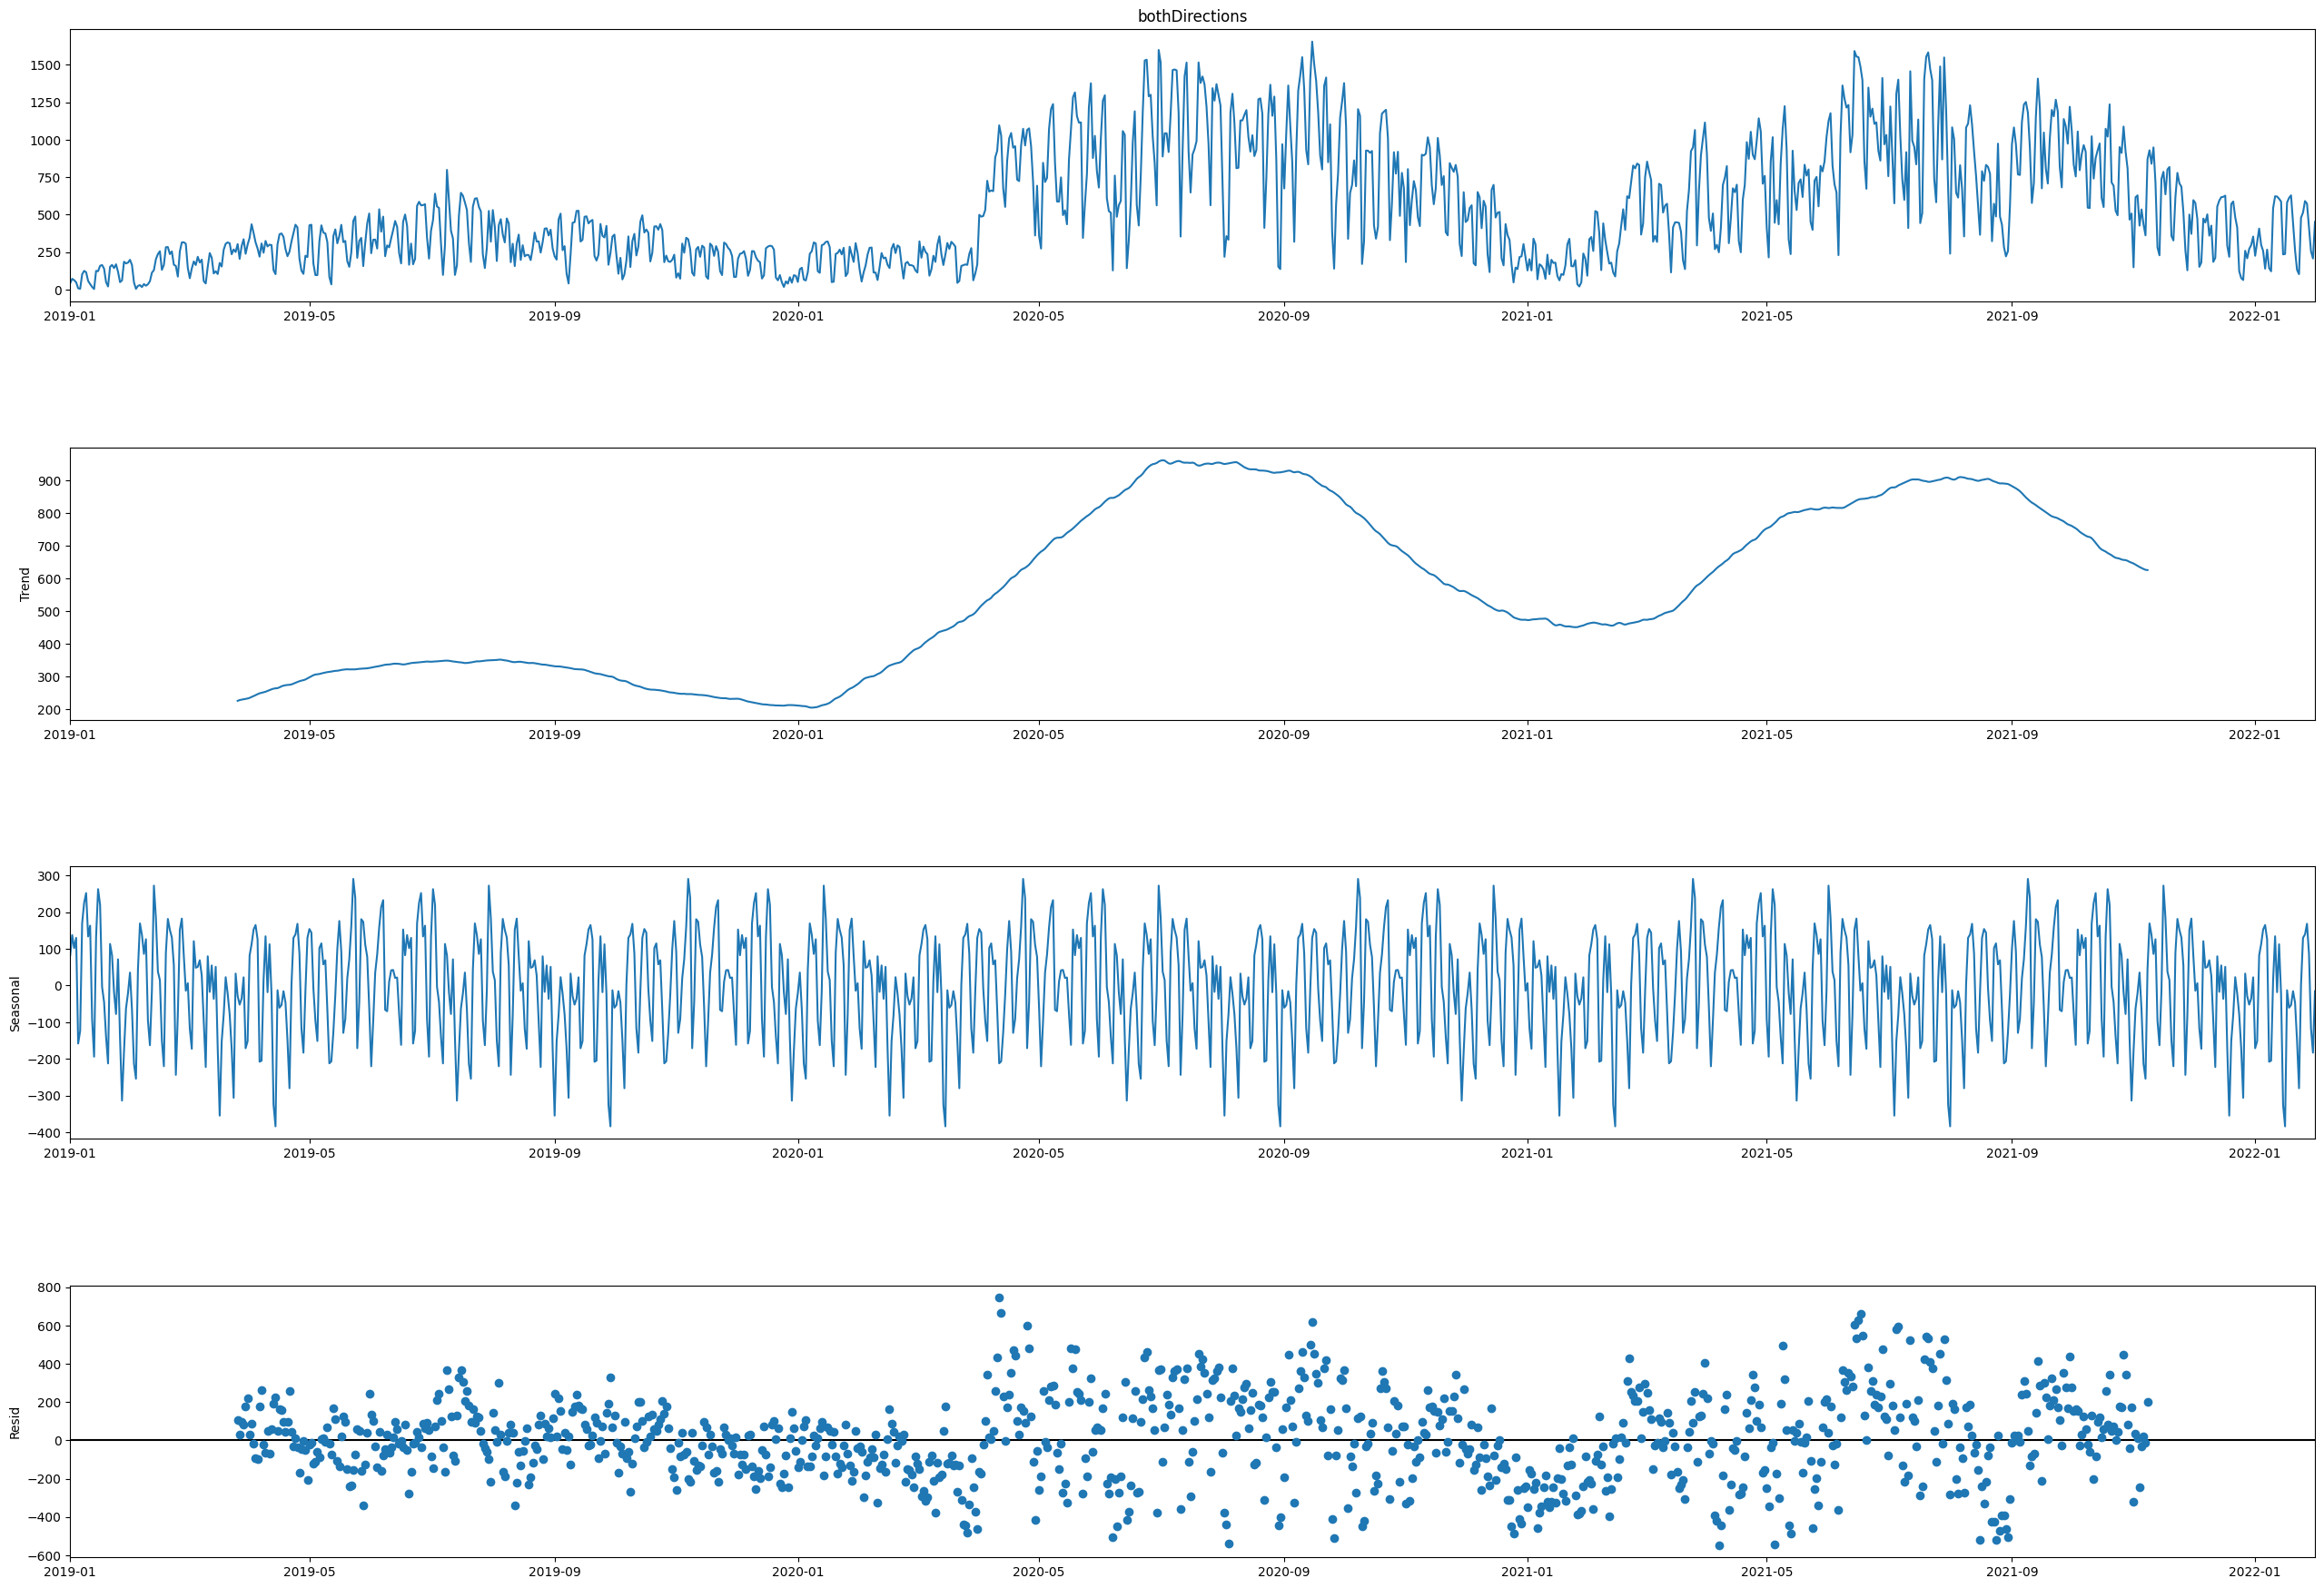

In [47]:
fig = decomp_additive2.plot()
fig.set_size_inches((30,20));

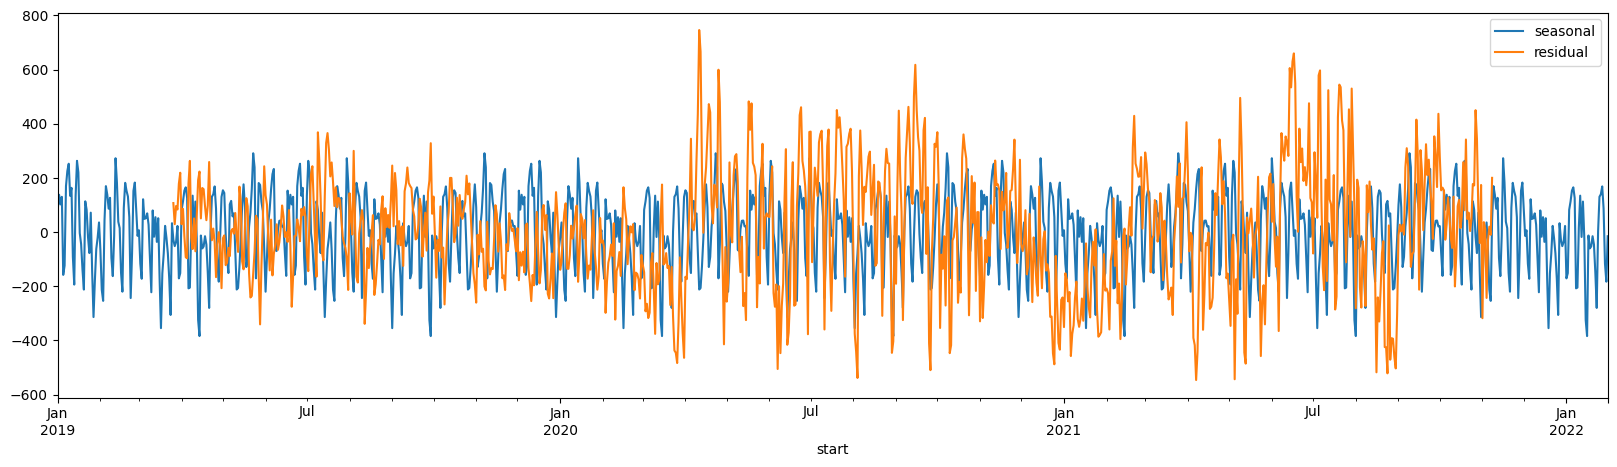

In [48]:
df_decomp_additive2.filter(['seasonal','residual']).plot(figsize=(20,5));

### **Decomposição clássica multiplicativa**

A decomposição clássica multiplicativa é um método para decompor uma série temporal em três componentes principais: tendência, sazonalidade e componente residual. Ao contrário da decomposição aditiva, que assume que a série temporal é uma soma das três componentes, a decomposição multiplicativa assume que a série temporal é uma multiplicação dessas três componentes.

In [49]:
decomp_multip = seasonal_decompose(daily["bothDirections"], model='multiplicative')

df_decomp_multip = pd.DataFrame({'observed': decomp_multip.observed,
                                 'trend': decomp_multip.trend,
                                 'seasonal': decomp_multip.seasonal,
                                 'residual': decomp_multip.resid})
df_decomp_multip.head(10)

observed      trend  seasonal  residual
start                                              
2019-01-01      43.0        NaN  1.173204       NaN
2019-01-02      72.0        NaN  1.174058       NaN
2019-01-03      63.0        NaN  1.168497       NaN
2019-01-04      49.0  49.000000  1.095917  0.912478
2019-01-05       9.0  60.714286  0.682209  0.217287
2019-01-06       5.0  67.000000  0.611939  0.121951
2019-01-07     102.0  66.285714  1.094176  1.406349
2019-01-08     125.0  64.571429  1.173204  1.650046
2019-01-09     116.0  65.857143  1.174058  1.500256
2019-01-10      58.0  65.714286  1.168497  0.755337

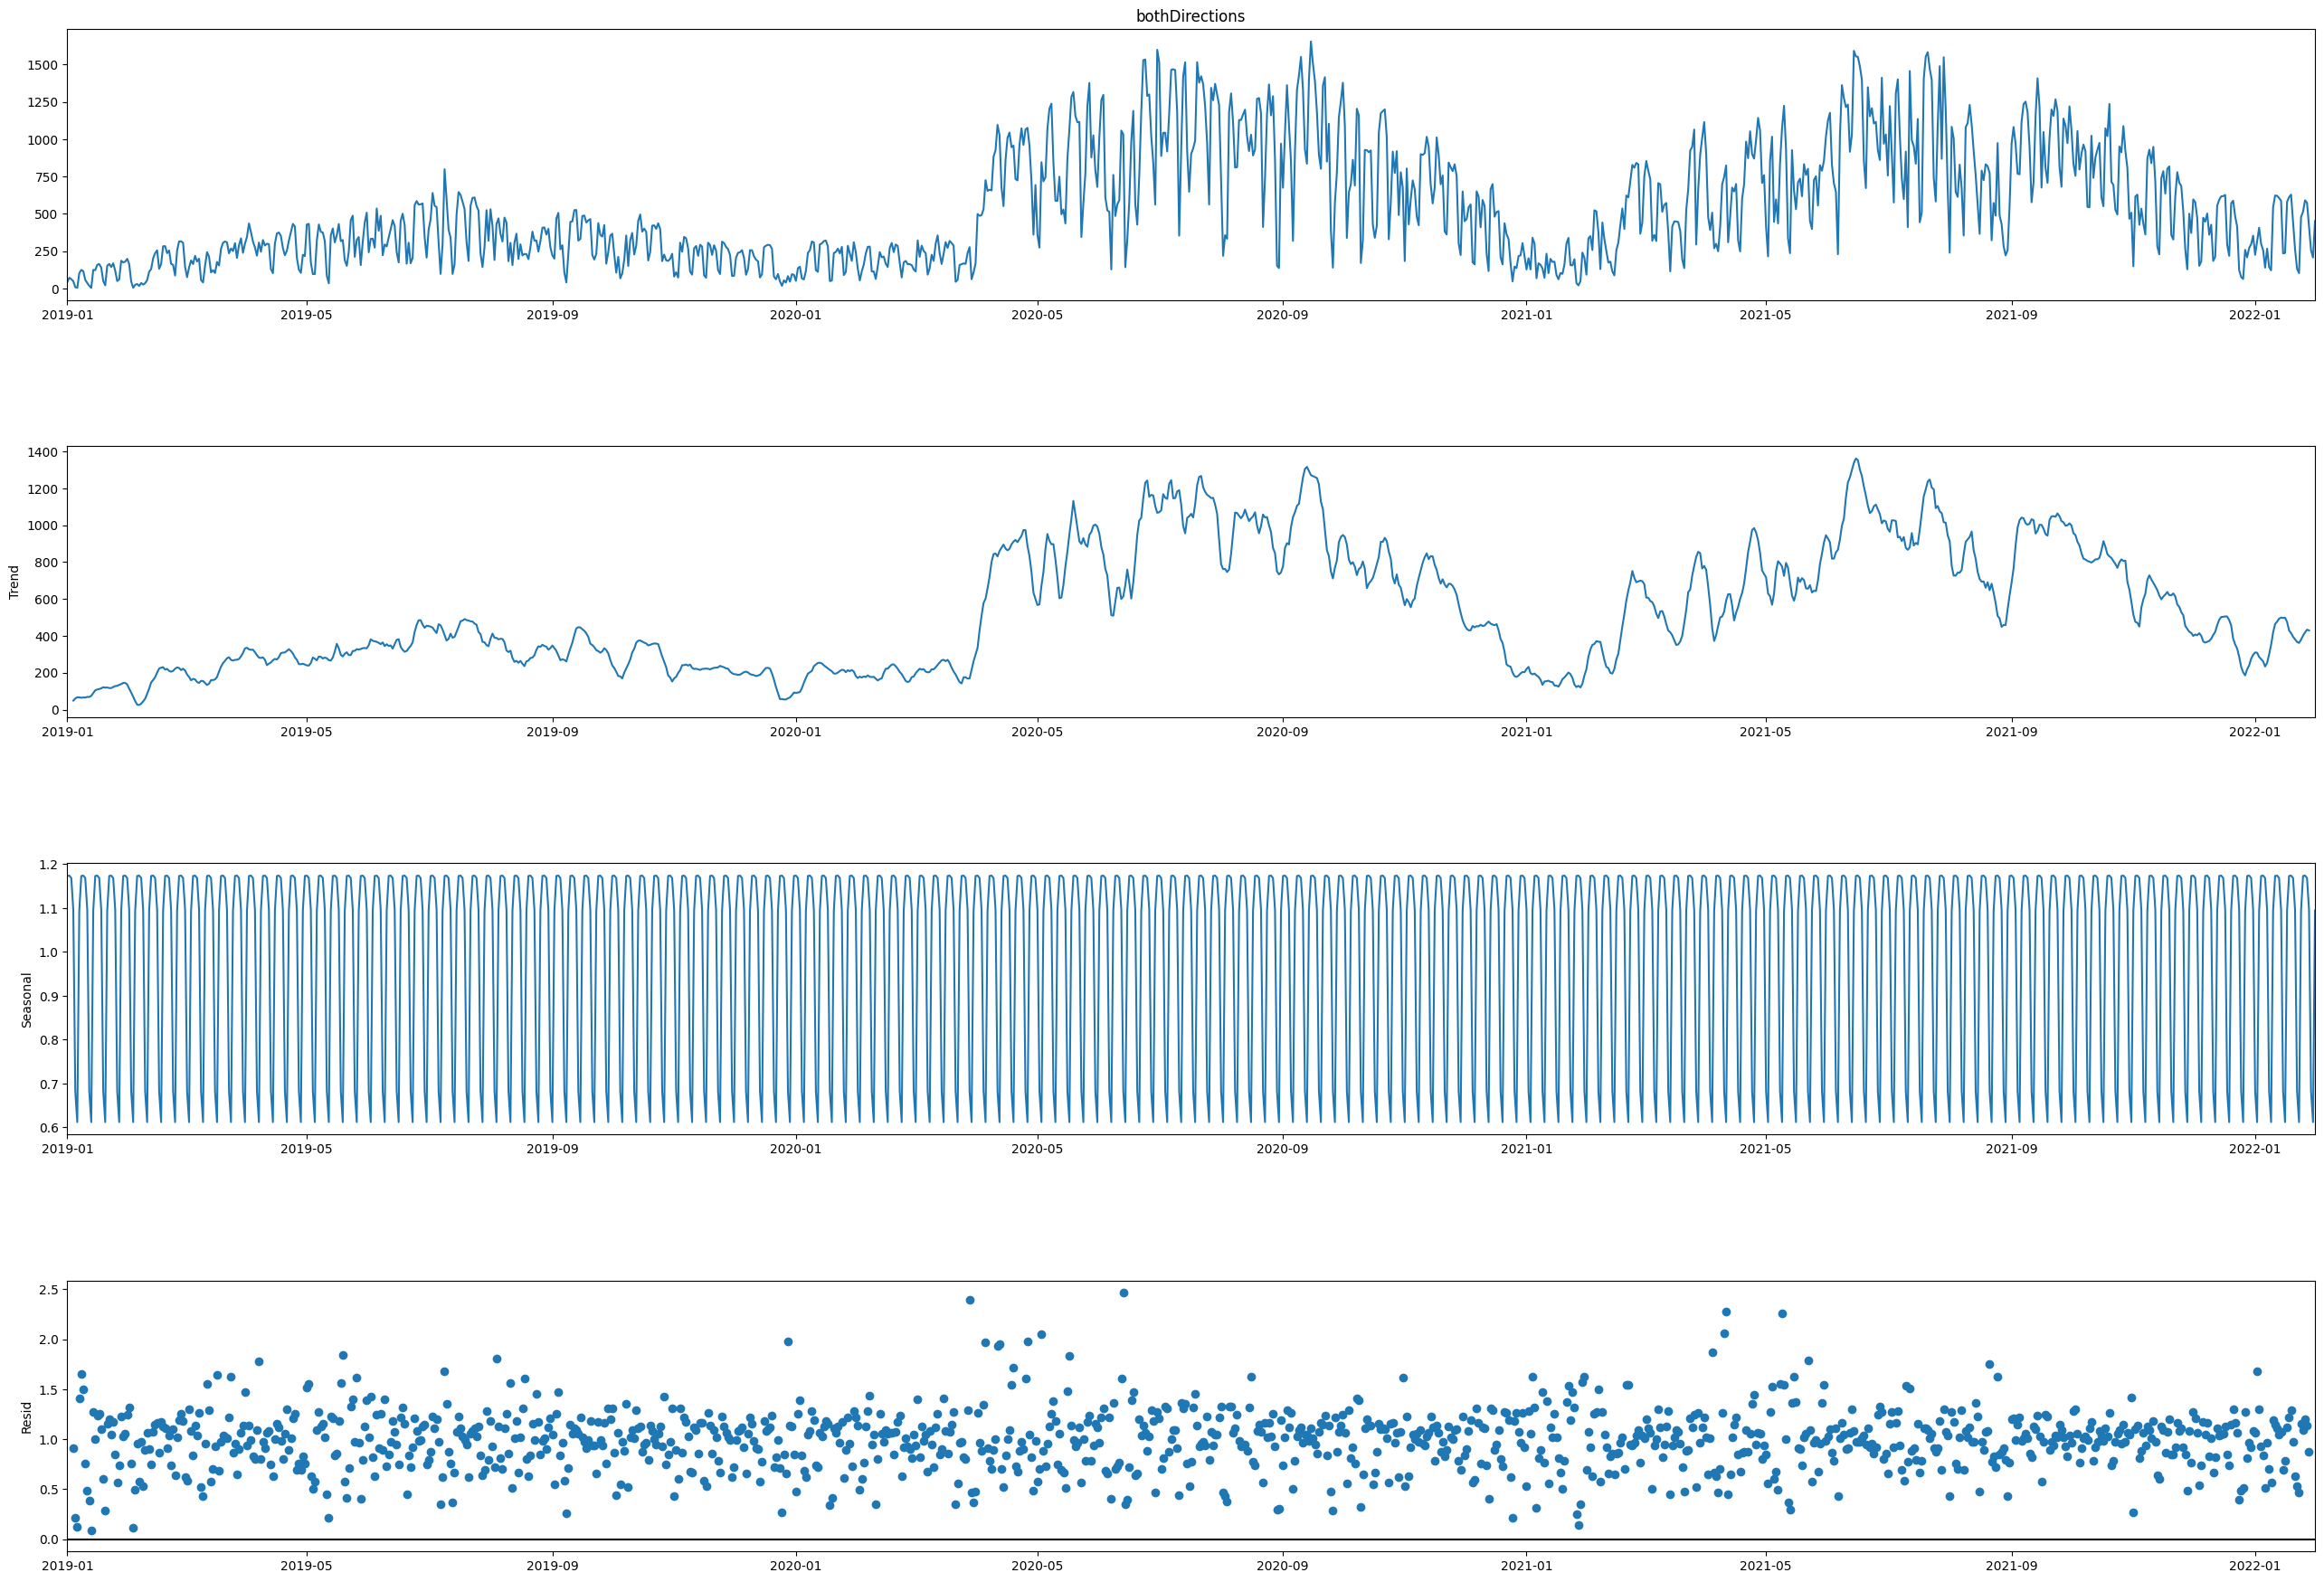

In [50]:
fig = decomp_multip.plot()
fig.set_size_inches((30,20));

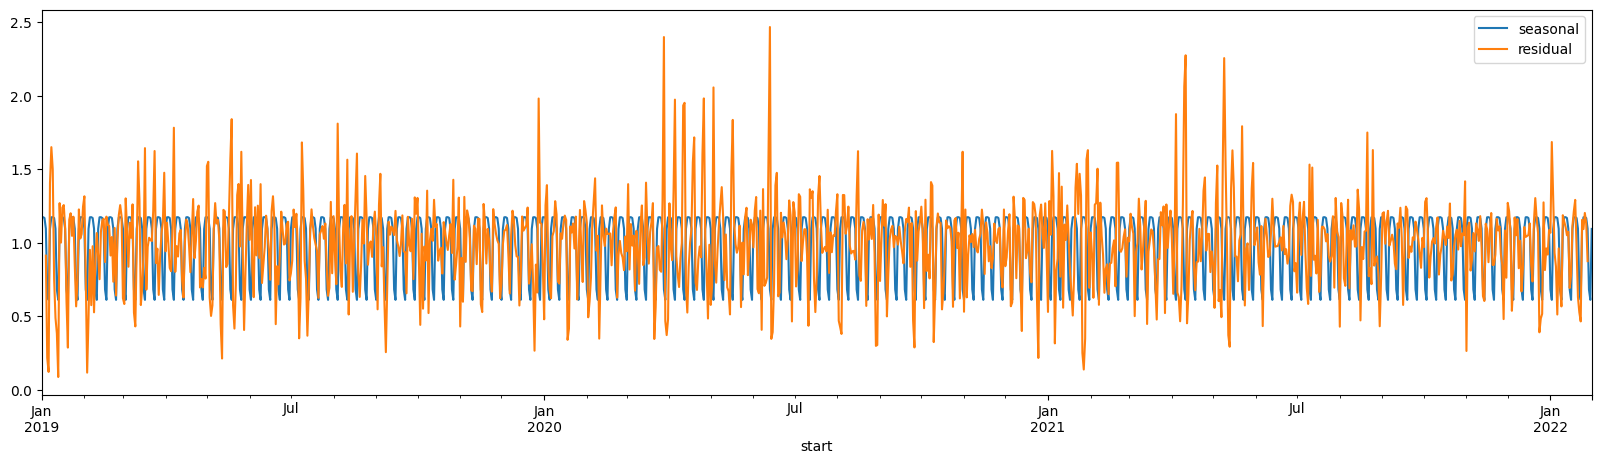

In [51]:
df_decomp_multip.filter(['seasonal','residual']).plot(figsize=(20,5));

Tal como fizémos na decomposição anterior, vamos replicar estes passos utilizando period=168:

In [52]:
decomp_multip3 = seasonal_decompose(daily["bothDirections"], model='multiplicative',period = 168)

df_decomp_multip3 = pd.DataFrame({'observed': decomp_multip3.observed,
                                 'trend': decomp_multip3.trend,
                                 'seasonal': decomp_multip3.seasonal,
                                 'residual': decomp_multip3.resid})
df_decomp_multip3.head(10)

observed  trend  seasonal  residual
start                                          
2019-01-01      43.0    NaN  1.183485       NaN
2019-01-02      72.0    NaN  1.248689       NaN
2019-01-03      63.0    NaN  1.140011       NaN
2019-01-04      49.0    NaN  1.190161       NaN
2019-01-05       9.0    NaN  0.697150       NaN
2019-01-06       5.0    NaN  0.769189       NaN
2019-01-07     102.0    NaN  1.353986       NaN
2019-01-08     125.0    NaN  1.430018       NaN
2019-01-09     116.0    NaN  1.437428       NaN
2019-01-10      58.0    NaN  1.278250       NaN

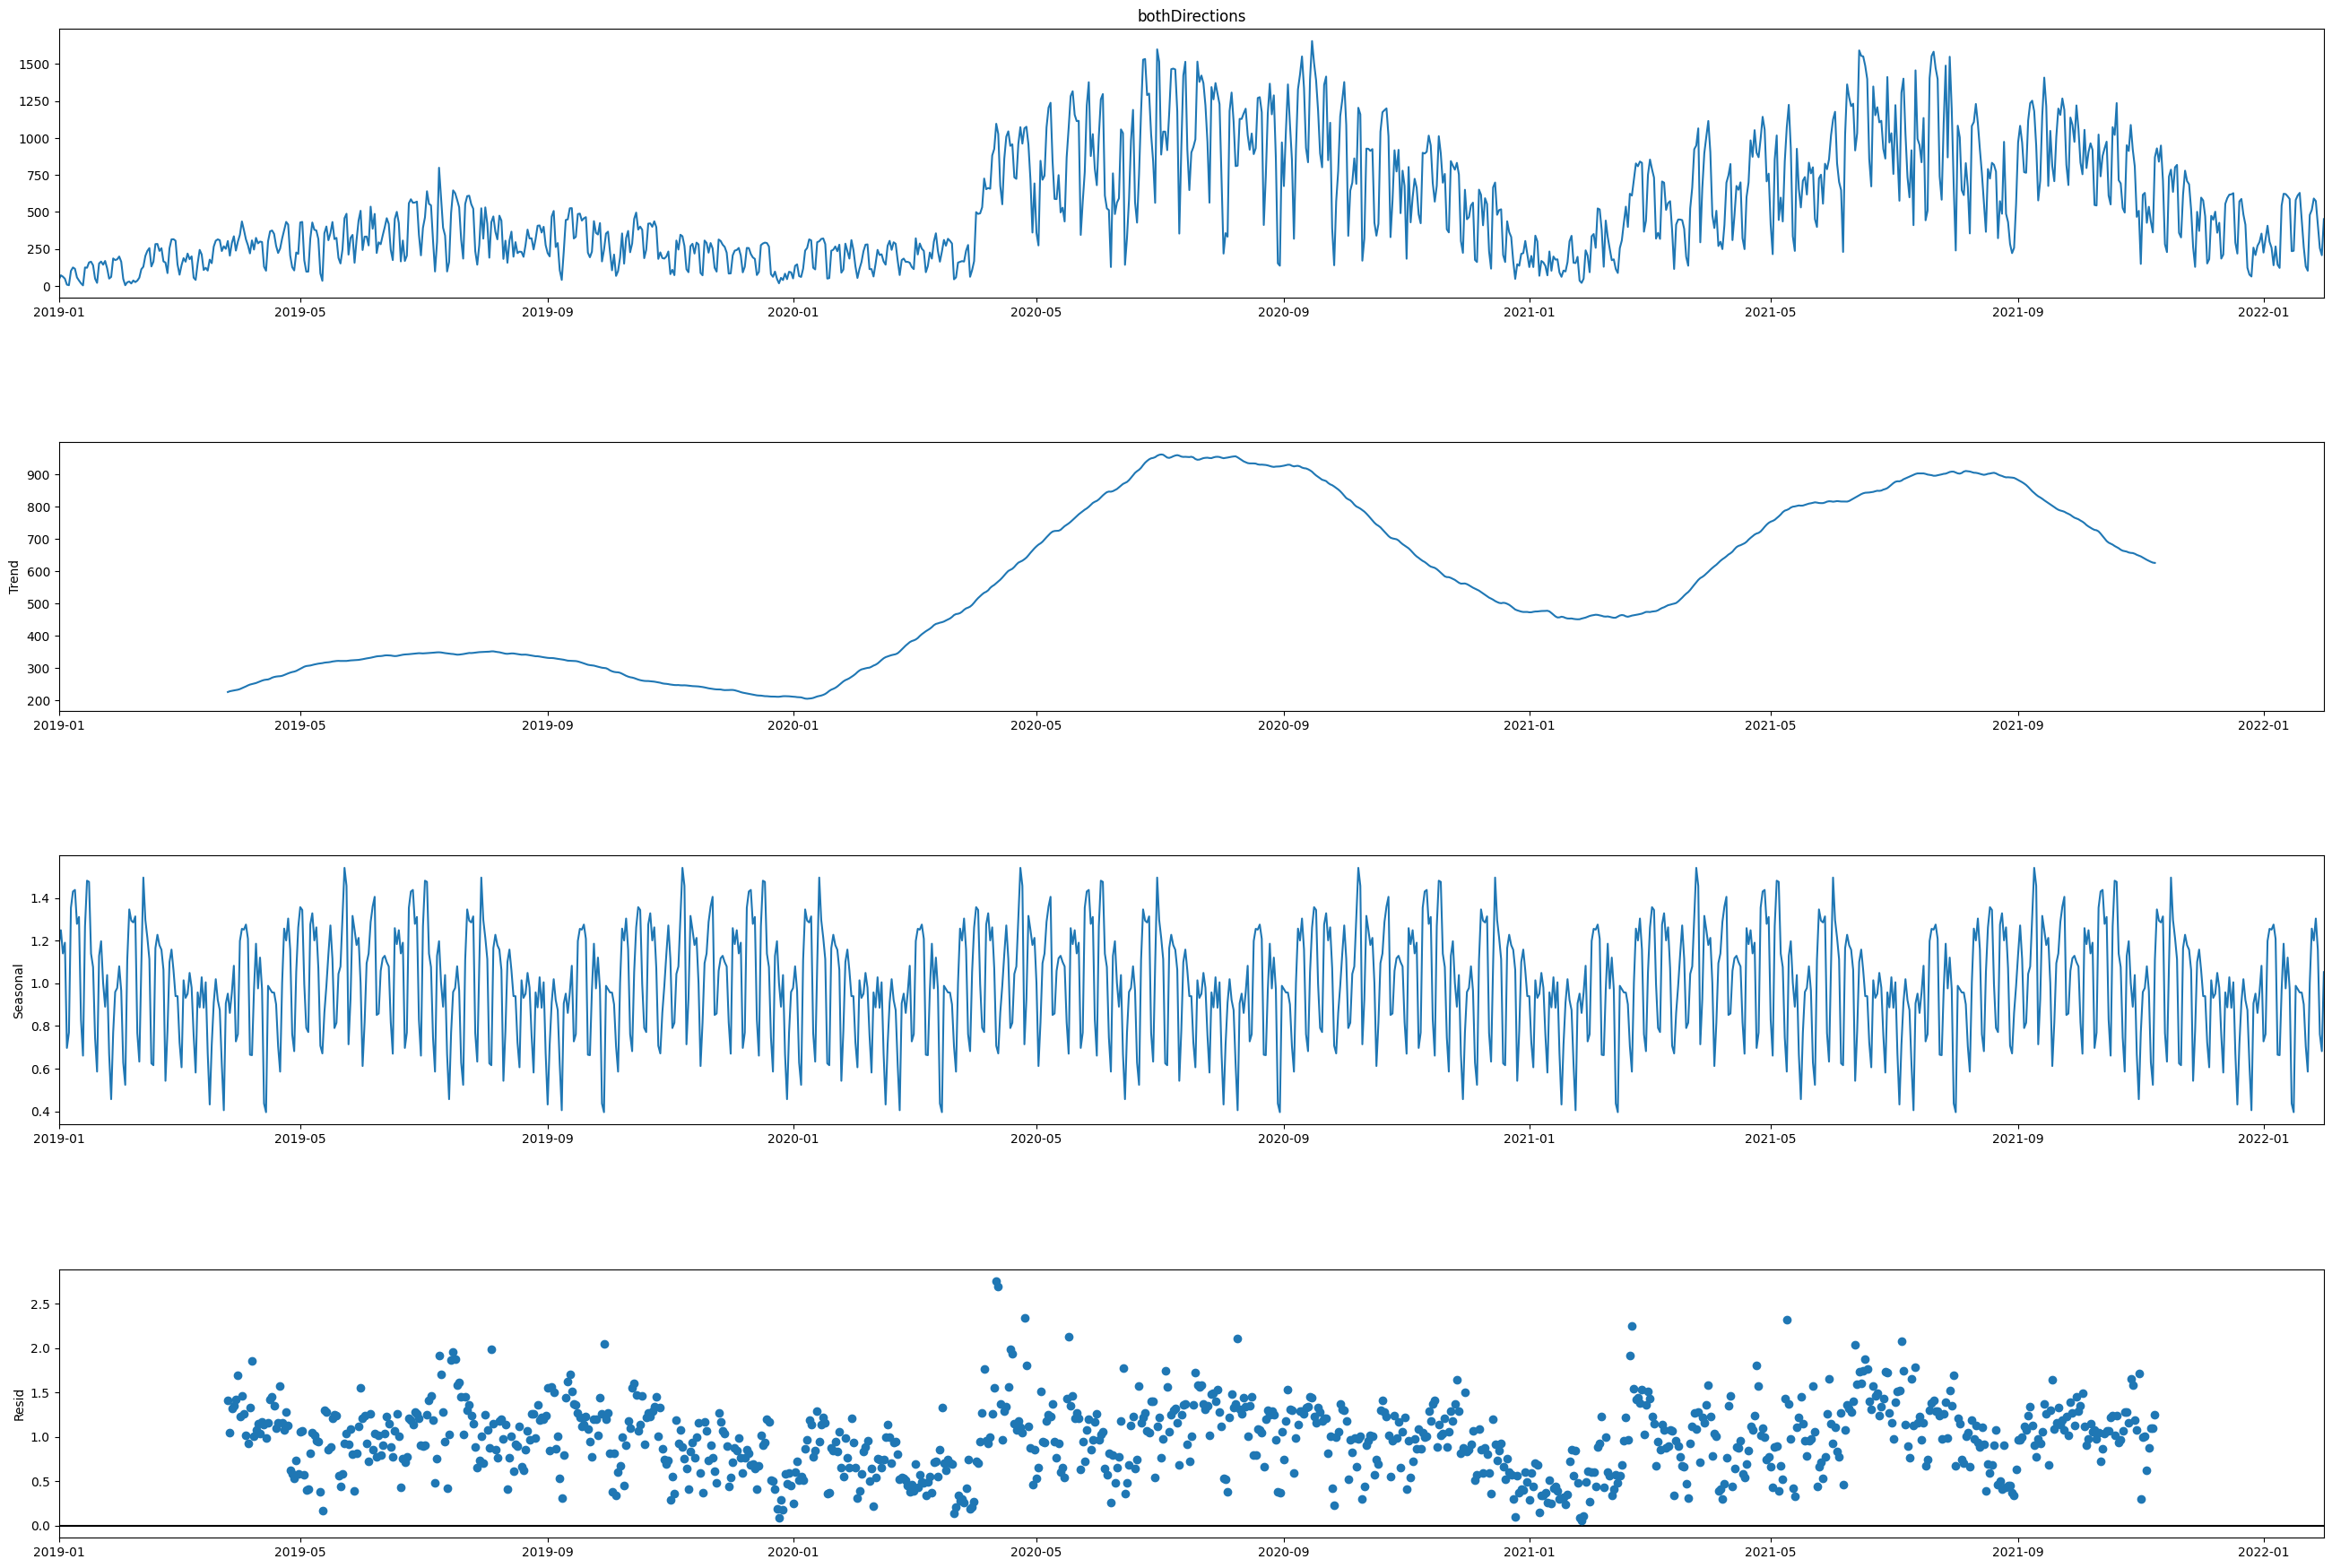

In [53]:
fig = decomp_multip3.plot()
fig.set_size_inches((30,20));

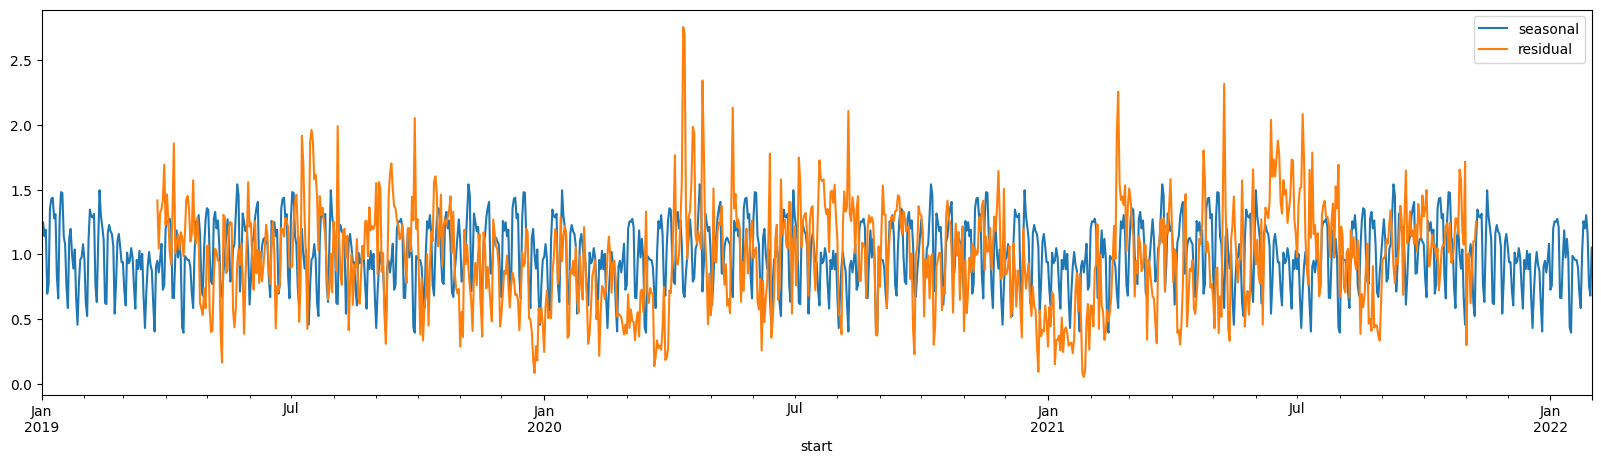

In [54]:
df_decomp_multip3.filter(['seasonal','residual']).plot(figsize=(20,5));

**Conclusão - As abordagens de decomposição clássica, tanto a aditiva como a multiplicativa, apresentam resultados semelhantes. Na primeira decomposição, apresentam uma linha de tendência robusta com demasiadas flutuações, na sazonalidade fica exposta a sua limitação em que mostra apenas o mesmo padrão repetidamente. Quando mudamos o período para 168, as linhas de tendência suavizam, e a sazonalidade mostra o seu padrão de uma maneira mais percetível. Quanto aos resíduos, nas visualizações que os comparam à sazonalidade, é percetível que estes estão demasiado afastados da linha da sazonalidade, mais uma vez comprovando que estas decomposições não são ideias para esta série**

De seguida apresentam-se estas abordagens com um período de 70:

In [55]:
decomp_multip4 = seasonal_decompose(daily["bothDirections"], model='multiplicative',period = 168)

df_decomp_multip4 = pd.DataFrame({'observed': decomp_multip4.observed,
                                 'trend': decomp_multip4.trend,
                                 'seasonal': decomp_multip4.seasonal,
                                 'residual': decomp_multip4.resid})

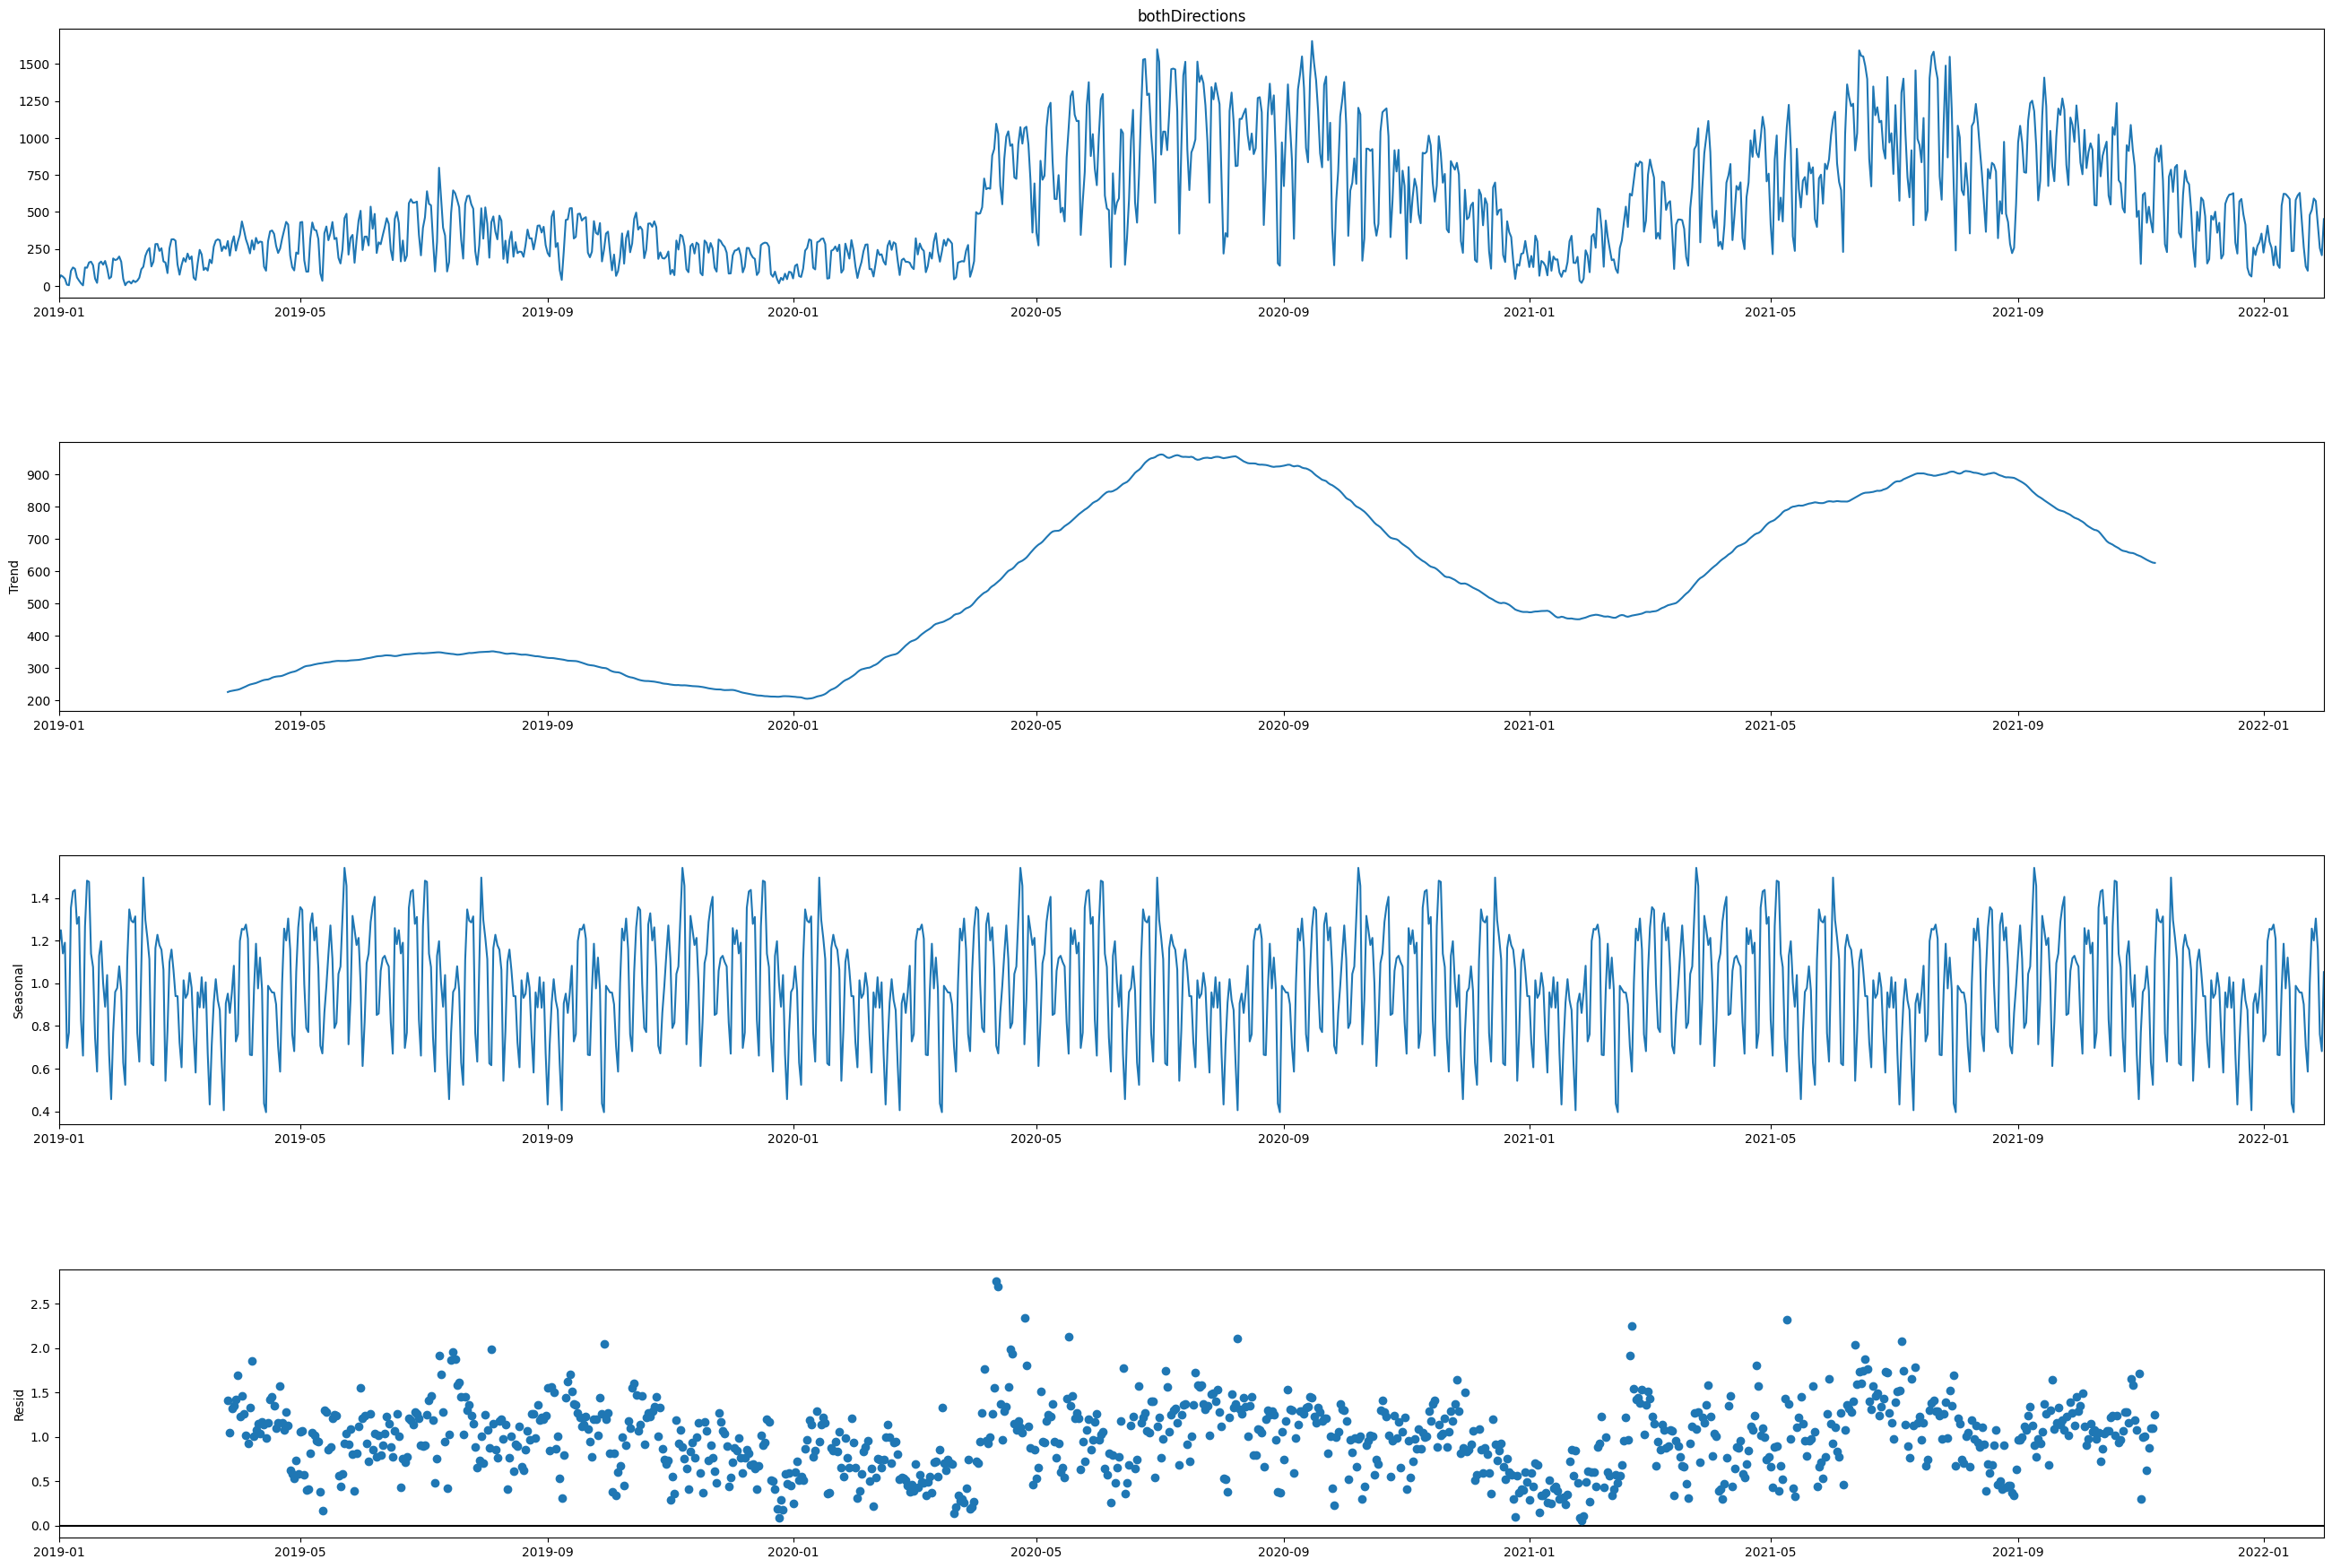

In [56]:
fig = decomp_multip4.plot()
fig.set_size_inches((30,20));

In [57]:
decomp_additive3 = seasonal_decompose(daily["bothDirections"], model='additive',period = 70)

df_decomp_additive3 = pd.DataFrame({'observed': decomp_additive3.observed,
                                   'trend': decomp_additive3.trend,
                                   'seasonal': decomp_additive3.seasonal,
                                   'residual': decomp_additive3.resid})

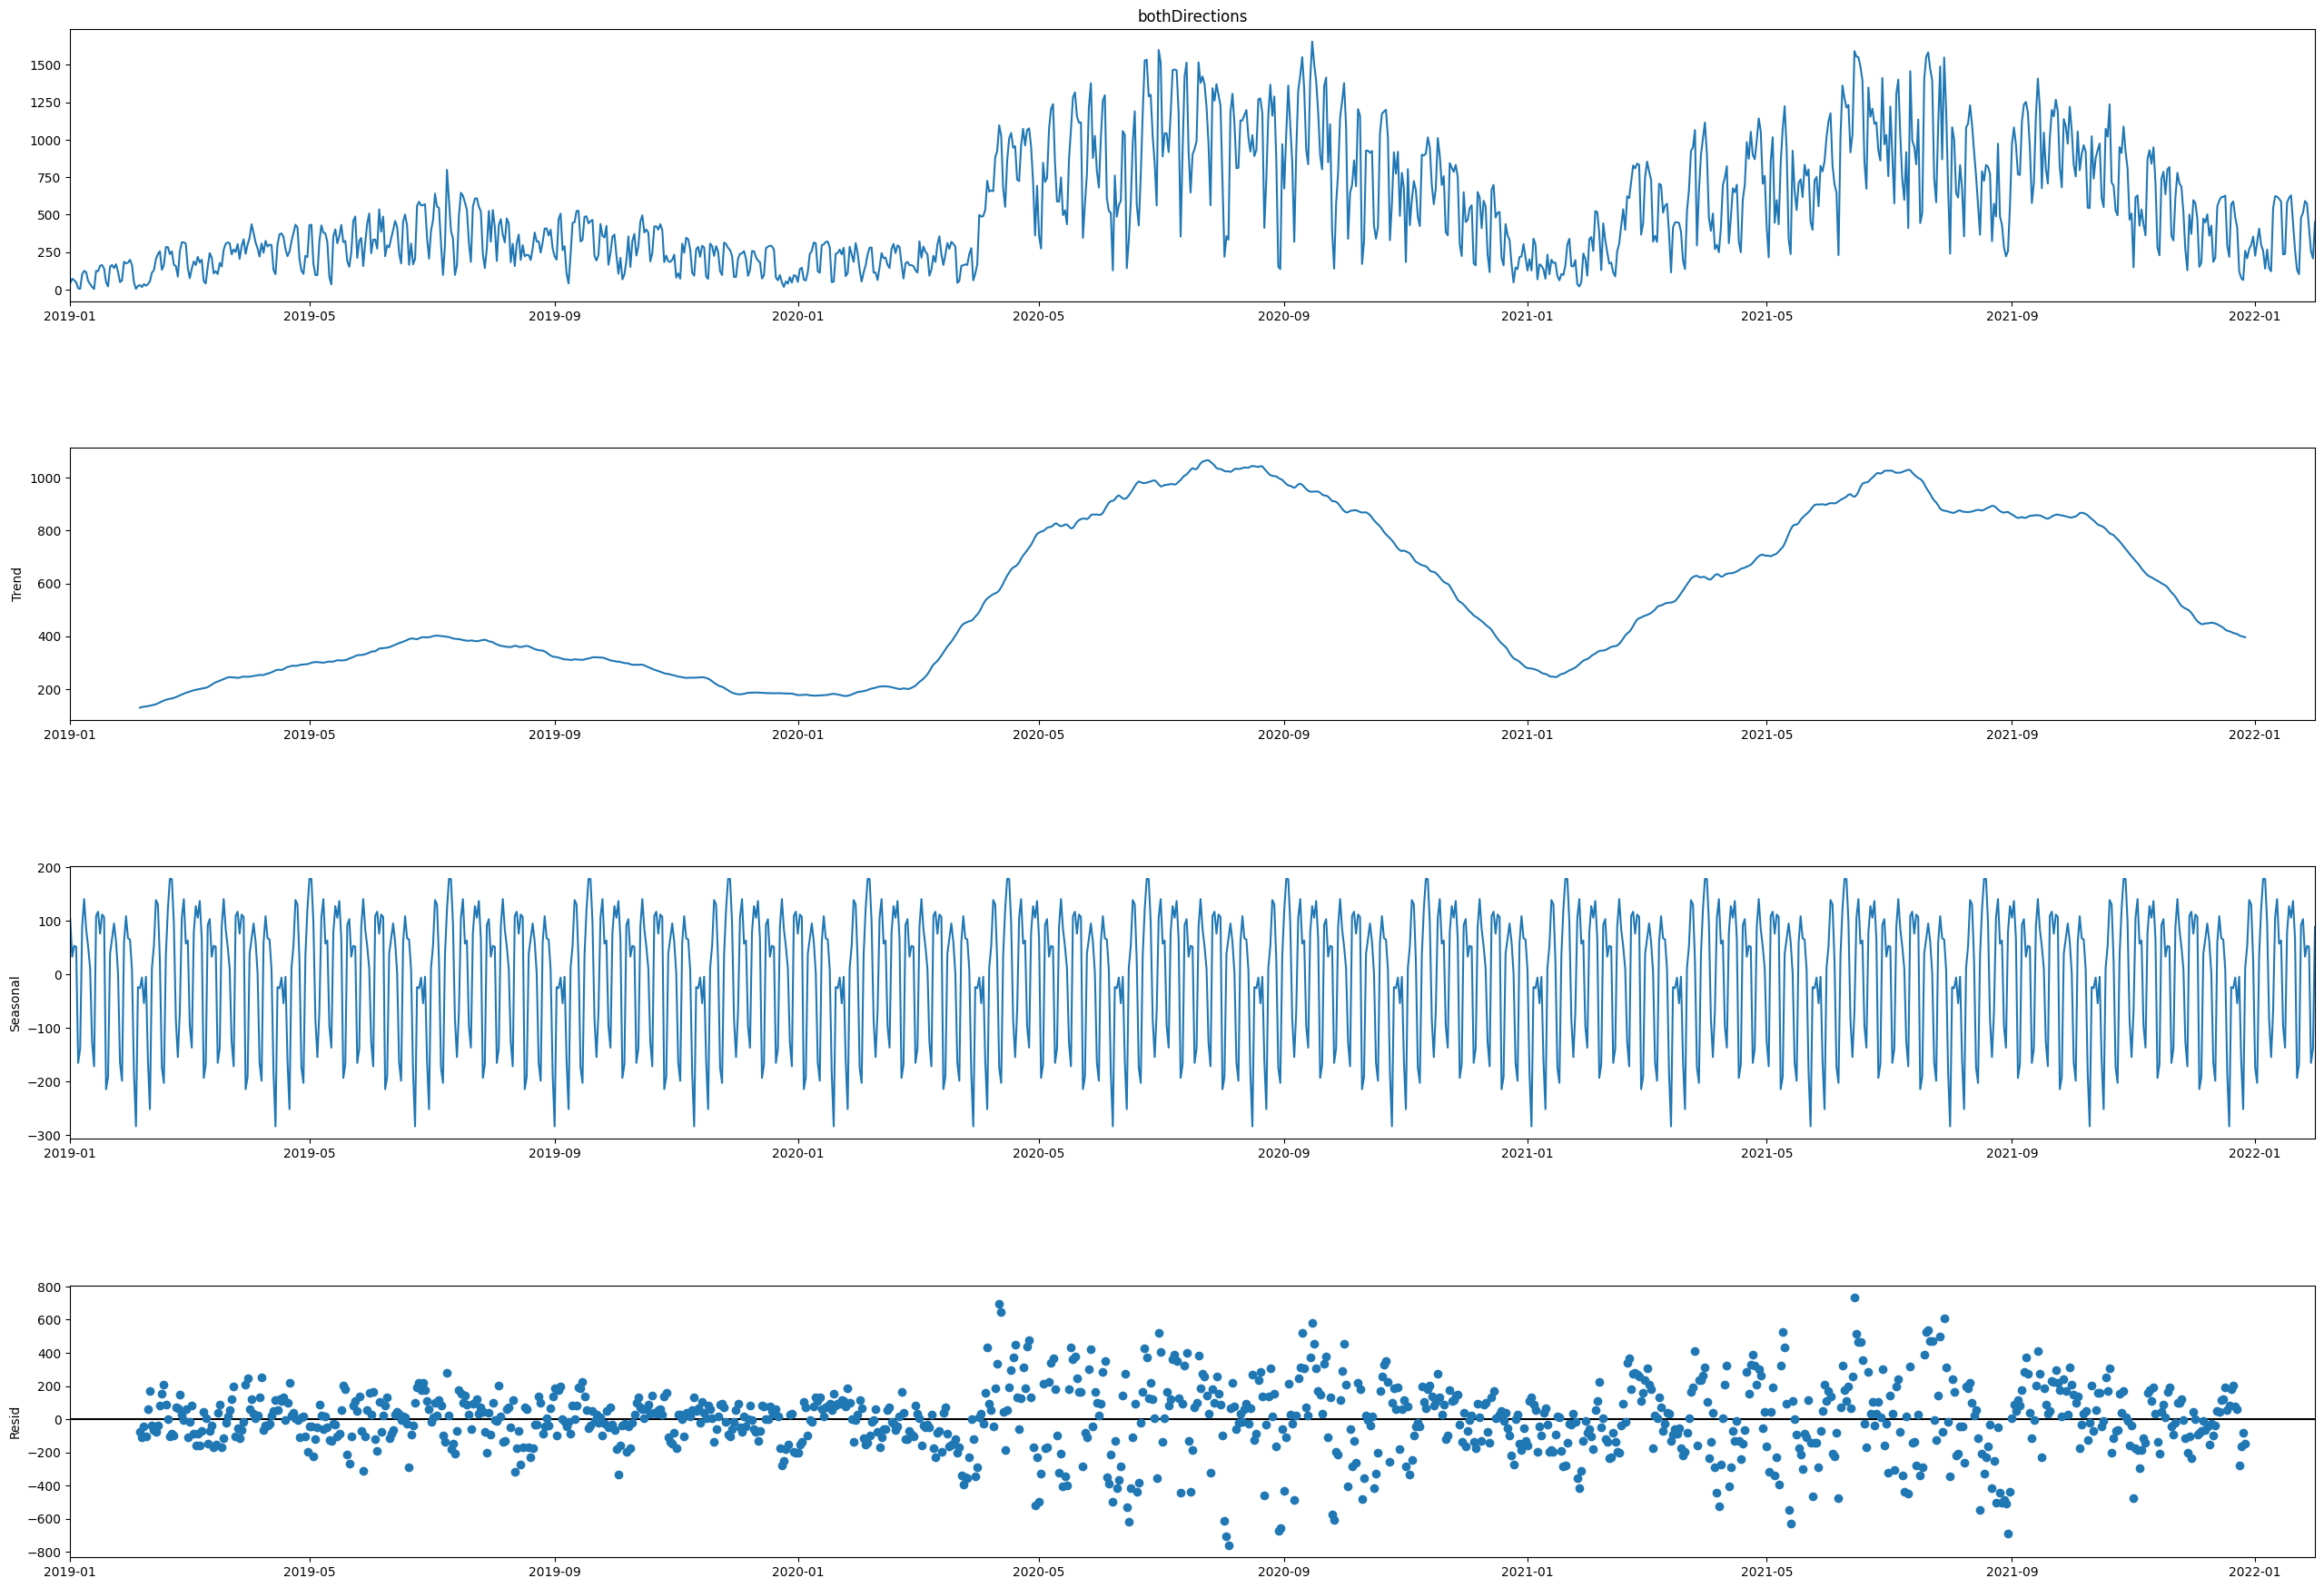

In [58]:
fig = decomp_additive3.plot()
fig.set_size_inches((30,20));

**Estas 2 decomposições clássicas com período 70 foram feitas para serem comparadas com a próxima decomposição STL, no entanto as conclusões anteriores também se aplicam aqui**

### **Decomposição STL**

A decomposição STL (Seasonal and Trend decomposition using Loess) é um método mais avançado para decompor uma série temporal em três componentes principais: tendência, sazonalidade e componente residual. Para aplicar a decomposição multiplicativa é necessário aplicar o logaritmo e, no final, reverter essa transformação nas componentes.

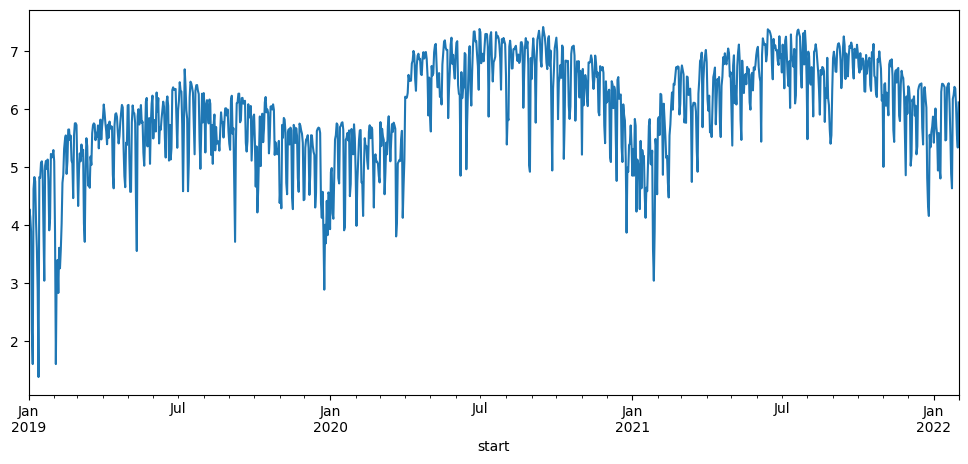

In [59]:
log_bothDirections = np.log(daily["bothDirections"])

log_bothDirections.plot(figsize=(12,5));

In [60]:
decomp_stl_raw = STL(log_bothDirections, seasonal=13)
decomp_stl= decomp_stl_raw.fit()

df_decomp_stl = pd.DataFrame({'observed': np.exp(decomp_stl.observed.squeeze()),
                              'trend': np.exp(decomp_stl.trend),
                              'seasonal': np.exp(decomp_stl.seasonal),
                              'residual': np.exp(decomp_stl.resid)})
df_decomp_stl.head(10)

observed      trend  seasonal  residual
start                                              
2019-01-01      43.0  24.614423  2.132398  0.819239
2019-01-02      72.0  27.104874  2.407141  1.103529
2019-01-03      63.0  29.777477  1.877099  1.127108
2019-01-04      49.0  32.631069  1.322449  1.135497
2019-01-05       9.0  35.609825  0.363910  0.694510
2019-01-06       5.0  38.557409  0.117826  1.100581
2019-01-07     102.0  41.053935  2.062993  1.204336
2019-01-08     125.0  41.470370  1.966097  1.533088
2019-01-09     116.0  41.575506  2.141687  1.302760
2019-01-10      58.0  41.934462  1.803857  0.766752

In [61]:
decomp_stl_raw.config

{'period': 7,
 'seasonal': 13,
 'seasonal_deg': 1,
 'seasonal_jump': 1,
 'trend': 13,
 'trend_deg': 1,
 'trend_jump': 1,
 'low_pass': 9,
 'low_pass_deg': 1,
 'low_pass_jump': 1,
 'robust': False}

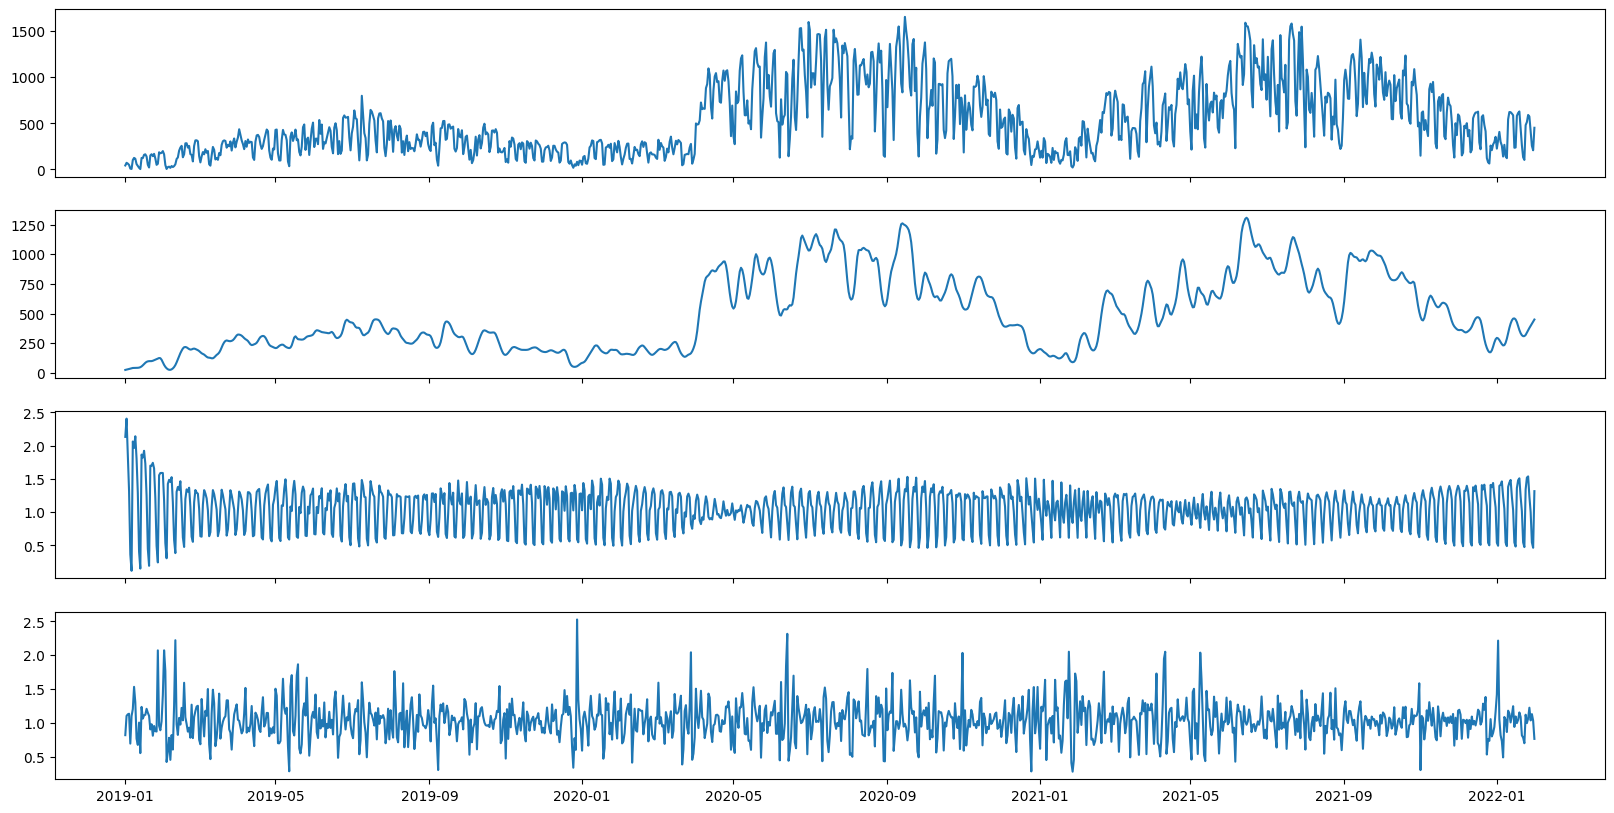

In [62]:
fig, ax = plt.subplots(4, 1, figsize=(20,10), sharex=True)
ax[0].plot(df_decomp_stl.observed)
ax[1].plot(df_decomp_stl.trend)
ax[2].plot(df_decomp_stl.seasonal)
ax[3].plot(df_decomp_stl.residual)
plt.show()

A seguir repete-se o mesmo processo com um período que suavize a linha da tendência e simultaneamente não se afaste do cronograma da série temporal:

In [63]:
decomp_stl_raw4 = STL(log_bothDirections,period = 70)
decomp_stl4= decomp_stl_raw4.fit()

df_decomp_stl4 = pd.DataFrame({'observed': np.exp(decomp_stl4.observed.squeeze()),
                              'trend': np.exp(decomp_stl4.trend),
                              'seasonal': np.exp(decomp_stl4.seasonal),
                              'residual': np.exp(decomp_stl4.resid)})
df_decomp_stl4.head(10)

observed      trend  seasonal  residual
start                                              
2019-01-01      43.0  44.402054  0.907602  1.067014
2019-01-02      72.0  45.326467  1.391056  1.141921
2019-01-03      63.0  46.269382  0.960001  1.418323
2019-01-04      49.0  47.231117  0.853191  1.215967
2019-01-05       9.0  48.211983  0.269421  0.692878
2019-01-06       5.0  49.212290  0.230816  0.440180
2019-01-07     102.0  50.232358  1.341337  1.513836
2019-01-08     125.0  51.272527  1.689076  1.443365
2019-01-09     116.0  52.333131  1.990260  1.113709
2019-01-10      58.0  53.414500  1.266034  0.857676

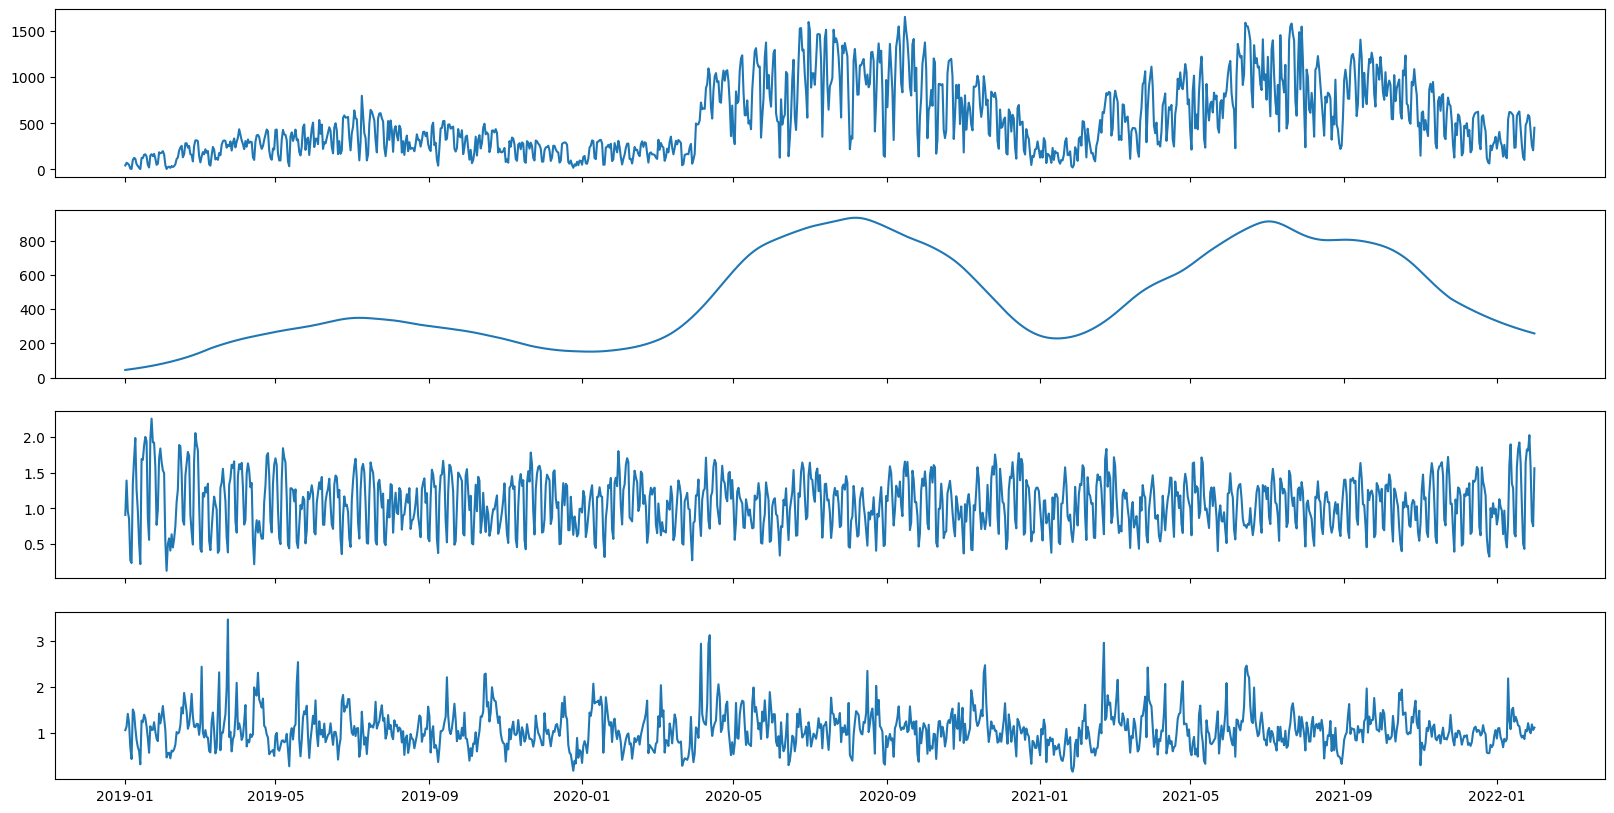

In [64]:
fig, ax = plt.subplots(4, 1, figsize=(20,10), sharex=True)
ax[0].plot(df_decomp_stl4.observed)
ax[1].plot(df_decomp_stl4.trend)
ax[2].plot(df_decomp_stl4.seasonal)
ax[3].plot(df_decomp_stl4.residual)
plt.show()

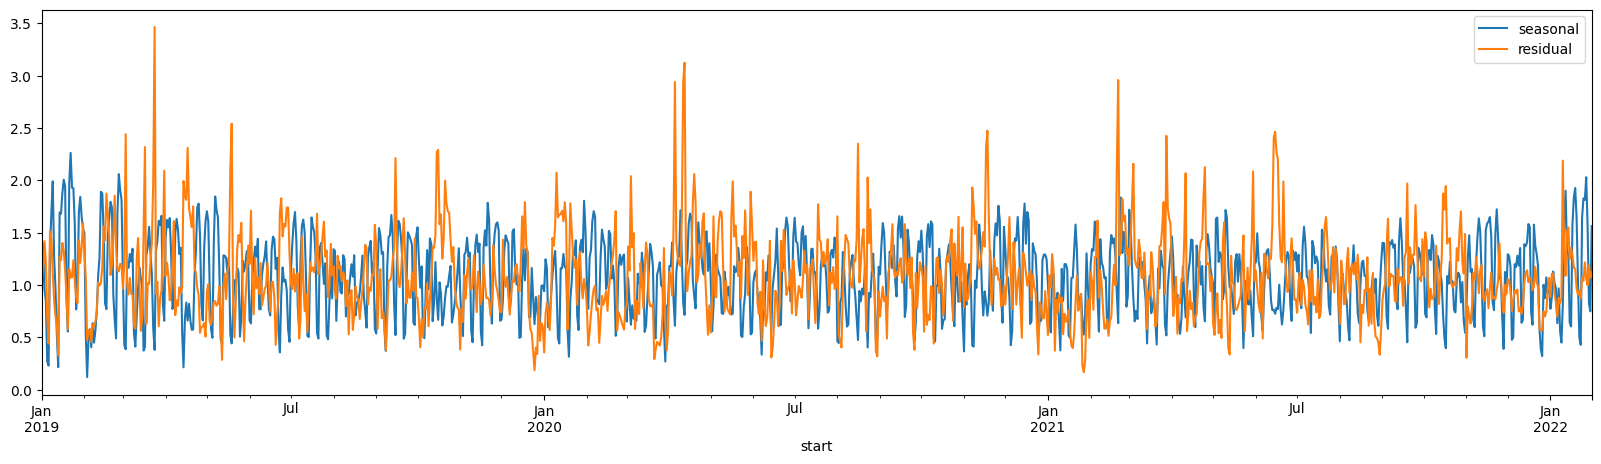

In [65]:
df_decomp_stl4.filter(['seasonal','residual']).plot(figsize=(20,5));

**Conclusão - A decomposição STL com período 70, comparando às clássicas com a mesma periodicidade, mostra uma linha de tendência muito mais suave, que simultaneamente mostra as mudanças na série temporal. A sazonalidade é também mais percetível, e os resíduos por sua vez estão muito mais ajustados ao gráfico de sazonalidade. Considera-se que esta foi a melhor decomposição.**

# _6. Exibir a linha de tendência

> **Tarefa 5:** Construir o cronograma da série a cinzento e juntar, escolhendo outra cor, a linha de tendência, com base na melhor tendência obtida na tarefa 4.

**O modelo aditivo deve ser usado quando as oscilações sazonais são de magnitude(aproximadamente) constante, apesar da tendência, isto é, quando a sazonalidade da série é aditiva**

**O modelo multiplicativo deve ser escolhido quando o tamanho das flutuações sazonais varia acompanhando a tendência, isto é, quando a sazonalidade da série é multiplicativa.**

**A abordagem STL é mais robusta em relação à presença de outliers e pode ser aplicada em séries temporais com padrões sazonais e de tendência complexos.**

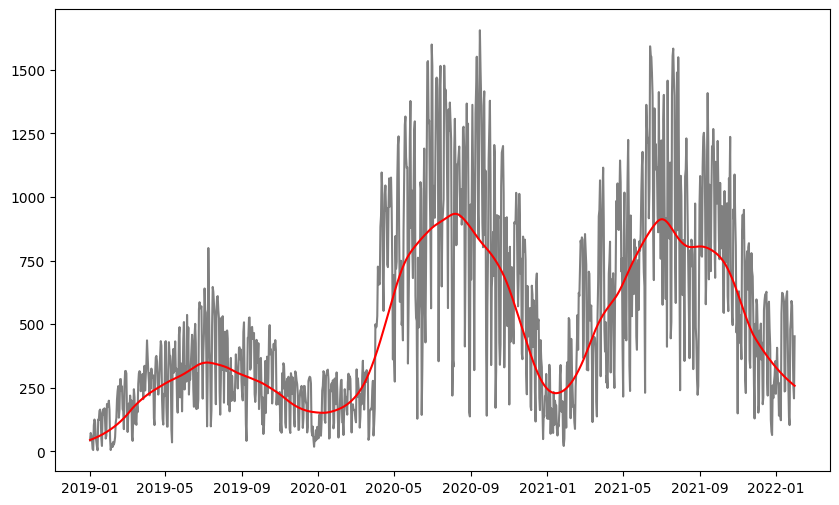

In [66]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(daily["bothDirections"] ,color='gray', label='Série Temporal')
ax.plot(df_decomp_stl4.filter(["trend"]),color="red",label="Linha de tendencia")

plt.show()

**Após analisar todas as linhas de tendência obtidas na tarefa 4, optámos por escolher a linha de tendência da decomposição STL com 70 períodos. Considerámos que este número de períodos era o que gerava uma linha de tendência simultaneamente mais suave e que se enquadre no cronograma da série temporal.**

# _7. *Outliers*

> **Tarefa 6:** Com base na melhor decomposição conseguida na tarefa 4, obter os *outliers* da série.

Encontrar os outliers de qualquer conjunto de dados e comhecer a sua dimensão é importante para entender que peso estes têm em todo o processo de análise. Há muitos testes estatísticos e técnicas de análise que são sensíveis a outliers, então é importante termos noção de quantos estão presentes.


**Há vários métodos para a classificação de outilers, um dos mais utilizados é o método de Tukey, que afirma que todos os valores inferiores ao Q1 - 1.5*AIQ e todos os superiores a Q3 + 1.5 AIQ são outilers. Utilizando este método obtem-se o seguinte resultado:**

In [67]:
def outlier_tukey(df, column):
   
    Q1 = df.quantile(0.25).loc[column]
    Q3 = df.quantile(0.75).loc[column]
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR
    df_outliers = df.query(f'{column} < @lower_fence or {column} > @upper_fence')
    return df_outliers

In [68]:
cm = sns.color_palette("vlag", as_cmap=True)

outliers = outlier_tukey(df_decomp_stl4, 'residual')

outliers.filter(['residual']).style.background_gradient(cmap=cm)

In [76]:
outliers.count()

observed    39
trend       39
seasonal    39
residual    39
dtype: int64

# _8. Visualizações

> **Tarefa 7:** Desenvolver duas visualizações (que podem incluir um gráfico e alguns outros números relevantes e que não têm que usar a série completa nem a periodicidade horária):
* a primeira para responder à pergunta: *A pandemia de COVID-19 levou a alguma alteração de comportamento?*
* a segunda para responder à pergunta: *Quando o tempo está mais ameno, há mais ciclistas?*

*Observação:* Não se pretende um *dashboard*. Apenas um gráfico, eventualmente anotado, e alguns números e texto a acompanhar.

Sugestões para, caso seja necessário, anotar os gráficos:
* Matplotlib - [axvline, axhline, axvspan, axhspan](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/axhspan_demo.html)
* Matplotlib - [text, figtext, annotate](https://python-charts.com/matplotlib/texts/)
* Plotly - [Horizontal and Vertical Lines and Rectangles in Python](https://plotly.com/python/horizontal-vertical-shapes/)

### **8.1 A pandemia de COVID-19 levou a alguma alteração de comportamento?**

Primeiramente para responder a esta questão temos que averiguar quais foram os períodos de confinamento na Alemanha relativos à pandemia. Destacam-se 3 rondas de confinamento:


1. Março a Abril de 2020: Durante este período, escolas, lojas e muitos estabelecimentos estiverem encerrados e foi pedido aos cidadãos para ficarem em casa o máximo possível.

2. Novembro de 2020 a Junho de 2021: Durante este período restaurantes, bares e todos os estabelecimentos não essenciais estiveram encerrados, e as escolas estiveram maioritariamente em modelo híbrido. As medidas de restrição começaram a levantar em Abril de 2021, e por Junho deste mesmo ano maior parte das restrições foram levantadas.

3. Em Dezembro de 2021 e Janeiro 2022 veio a terceira ronda de confinamento. Novamente ficaram fechados todos os negócios não essenciais, e foi pedido aos cidadãos que limitassem os seus contactos e permanecessem em casa.







Dado isto, começa-se por criar datasets distintos que englobem estas datas:

In [69]:
period1 = daily.loc['2020-03-01':'2020-04-30']
period2 = daily.loc['2020-11-01':'2021-06-30']
period3 = daily.loc['2021-12-01':'2022-01-31']

E agora constroem-se os gráficos que nos permitam responder a esta questão:

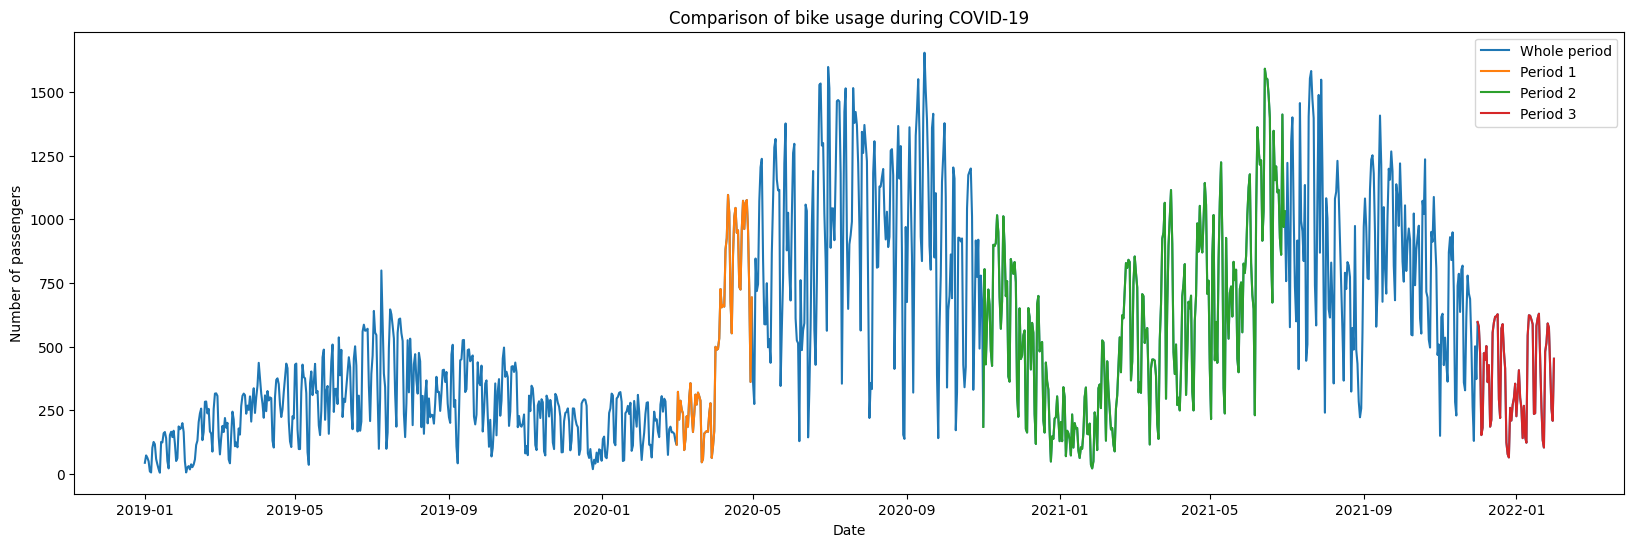

In [70]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 6))

plt.plot(daily.index, daily['bothDirections'], label='Whole period')

plt.plot(period1.index, period1['bothDirections'], label='Period 1')
plt.plot(period2.index, period2['bothDirections'], label='Period 2')
plt.plot(period3.index, period3['bothDirections'], label='Period 3')

plt.title('Comparison of bike usage during COVID-19')
plt.xlabel('Date')
plt.ylabel('Number of passengers')
plt.legend()

plt.show()


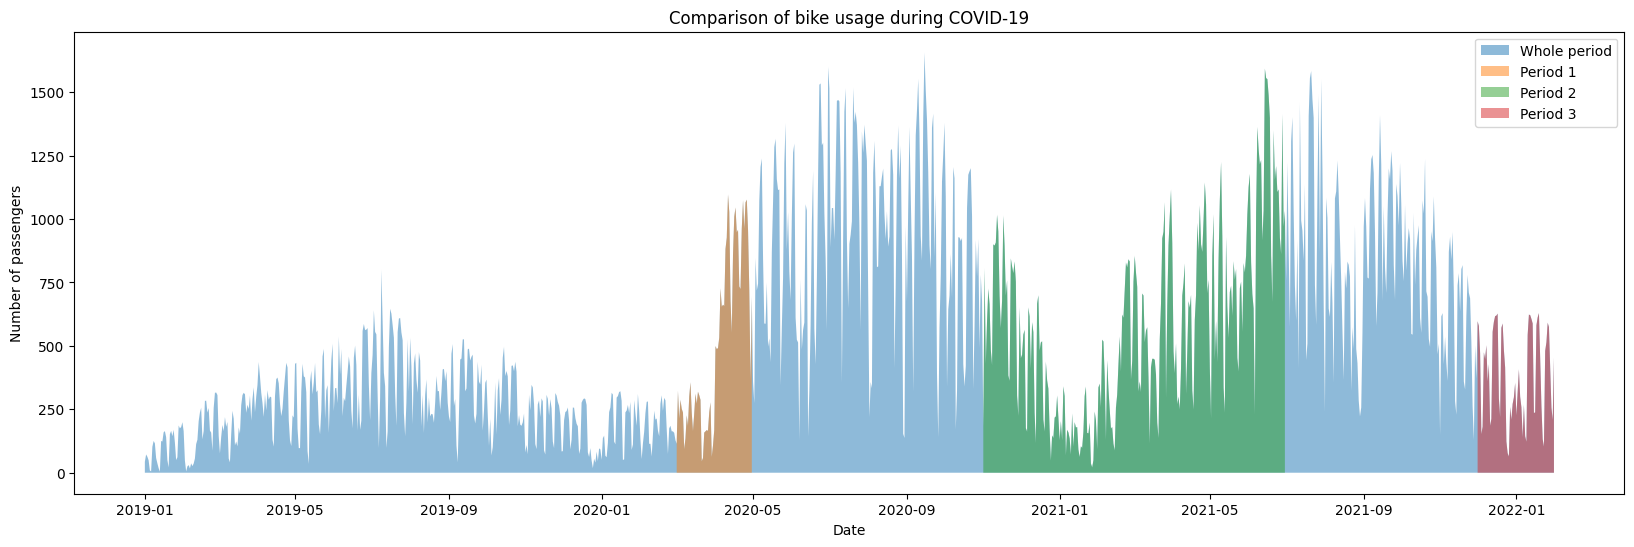

In [71]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 6))

plt.fill_between(daily.index, daily['bothDirections'], alpha=0.5, label='Whole period')

plt.fill_between(period1.index, period1['bothDirections'], alpha=0.5, label='Period 1')
plt.fill_between(period2.index, period2['bothDirections'], alpha=0.5, label='Period 2')
plt.fill_between(period3.index, period3['bothDirections'], alpha=0.5, label='Period 3')

plt.title('Comparison of bike usage during COVID-19')
plt.xlabel('Date')
plt.ylabel('Number of passengers')
plt.legend()

plt.show()


A seguir apresenta-se uma visualização semelhante às anteriores, mas feita utilizando a biblioteca plotly que nos dá uma interface mais interativa:

In [72]:
import plotly.graph_objs as go

trace1 = go.Scatter(x=daily.index, y=daily['bothDirections'], name='Whole period')

trace2 = go.Scatter(x=period1.index, y=period1['bothDirections'], name='Period 1')
trace3 = go.Scatter(x=period2.index, y=period2['bothDirections'], name='Period 2')
trace4 = go.Scatter(x=period3.index, y=period3['bothDirections'], name='Period 3')

data = [trace1, trace2, trace3, trace4]

layout = go.Layout(title='Comparison of bike usage during COVID-19',
xaxis=dict(title='Date'),
yaxis=dict(title='Number of passengers'))

fig = go.Figure(data=data, layout=layout)

fig.show()

Antes de analisar as visualizações apresentadas, tenha-se em conta que durante os períodos de confinamento, era permitido aos cidadãos a realização de atividades físicas singulares ao ar livre, sendo uma das principais o ciclismo.
Os 3 gráficos acima apresentados, demonstram o mesmo. A azul têm-se todos os períodos de tempo em que não se encontram em vigor qualquer tipo de restrições pandémicas. E as diferentes cores representam  os diferentes períodos de tempo correspondentes a cada uma das rondas de confinamento. Nota-se que antes da primeira ronda de confinamento, as passagens são muito inferiores às do restante dataset, isto pode inferir que estas primeiras restrições foram um propulsor para a aquisição de bicicletas ou da retoma da prática deste exercício por muitos dos cidadãos. Durante o segundo período consegue-se notar uma alta utilização de bicicletas, que mesmo comparando aos dados do ano anterior é muito superior, apesar de ter começado no Inverno. Por fim, a terceira ronda, veio mostrar valores sem precedentes para os meses de Dezembro e Janeiro

**Em suma:**

**1ª ronda: Pode-se apresentar a hipótese, que foi neste período de tempo que muitos cidadãos voltaram a andar, ou adquiriram uma bicicleta para poder andar no exterior durante o confinamento. Este hábito manteve-se e o aumento das passagens deu-se de uma forma incrível, mesmo após o confinamento estas pessoas continuaram a usar as bicicletas**
<p/>

**2ª ronda: O período de confinamento mais inconclusivo, visto que os valores apresentados, assumiram uma semelhança aos do ano seguinte, no entanto retrataram uma soma de passagens nunca antes vista durante os meses mais frios**
<p/>

**3ª ronda: Possivelmente devido à "frustração" dos cidadãos não quererem ficar em casa novamente, neste período temporal observaram-se valores incrivelmente altos para os meses de dezembro e janeiro**



### **8.2 Quando o tempo está mais ameno, há mais ciclistas?**

Para responder a esta pergunta, tem que se primeiramente definir, o que é que se considera tempo ameno? Para responder a esta questão vamos proceder a 2 abordagens:

1. Considera-se tempo ameno, quando não existir nenhuma situação climatérica extrema (como tempestades, neve...), quando não houver chuva, o céu estiver limpo, e a temperatura se encontre entre os 15-25 graus.
2. Considera-se tempo ameno pelas estações, ou seja favorecem-se os climas mais quentes ou de meia estação, e excluem-se os períodos mais frios e chuvosos, assim como os de calor mais intenso



**8.2.1 Céu limpo e temperatura aproximadamente entre os 15 e 25 graus**

Observando os valores da classificação contidos no ficheiro excel disponibilizado pela professora nota-se que apenas 2 das classificações se enquadram dentro dos nosso parâmetros estabelecidos: 'Moderate' e 'Warm'. A classificação 'Moderate' aplica-se quando a temperatura se encontra entre os 10 e 20 graus, e a 'Warm' quando esta assume valores entre 20 e 30 graus. Apesar de não ser exatamente o mesmo limite de temperaturas que definimos, é a opção mais perto que temos.
<p/>
Assim observe-se o gráfico seguinte pelas classificações especificadas:

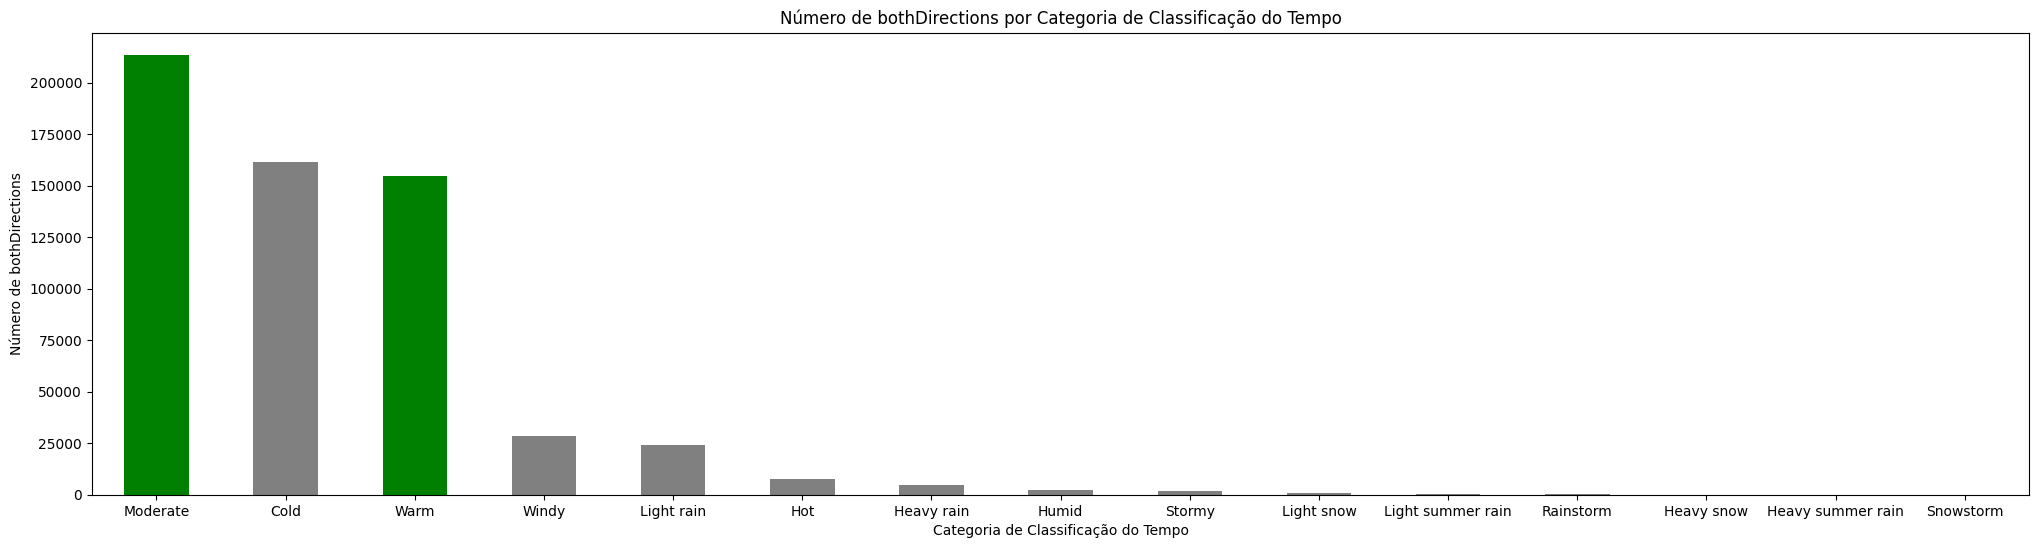

In [73]:
grouped = df.groupby('classification')['bothDirections'].sum()

grouped = grouped.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(25, 6))
grouped.plot(kind='bar', ax=ax, color=['gray' if x not in ['Warm', 'Moderate'] else 'green' for x in grouped.index])

plt.title('Número de bothDirections por Categoria de Classificação do Tempo')
plt.xlabel('Categoria de Classificação do Tempo')
plt.ylabel('Número de bothDirections')

ax.set_xticklabels(grouped.index, rotation=0)

plt.show()

Como se pode observar, a utilização de bicicletas é esmagadoramente maior nas classificações escolhidas. A verde destacadas, repara-se que a soma destas 2 é vastamente superior a todas as restantes juntas.

**8.2.1 Clima ameno associado a estações**

Aqui vamos considerar a primavera e o outono como um todo, visto que maioritariamente nestes meses se diz que o tempo está ameno (nem quente nem frio), e consideramos também o verão, excluindo Agosto que é comumente o mês de maior calor, um calor extremo não pode ser considerado neste caso.

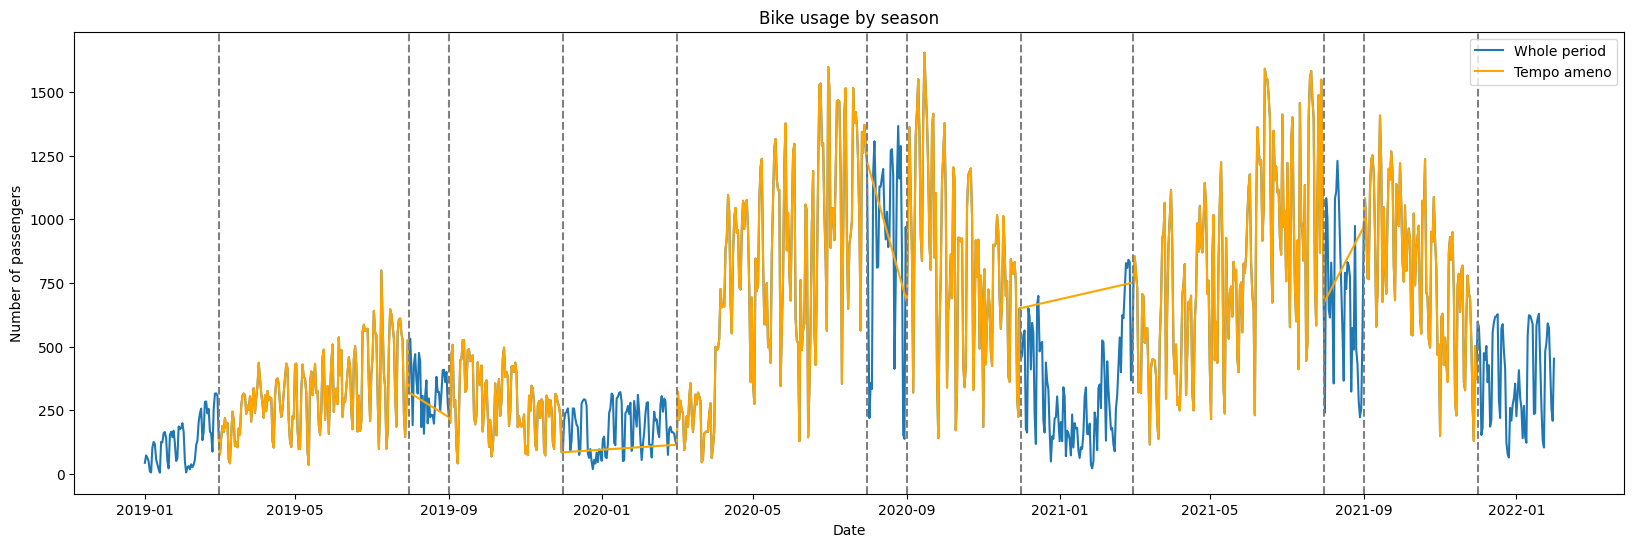

In [93]:
mask = ((daily.index.month >= 3) & (daily.index.month <= 5)) | ((daily.index.month >= 9) & (daily.index.month <= 11)) | ((daily.index.month >= 6) & (daily.index.month <= 7) & (daily.index.day <= 31))
fig, ax = plt.subplots(figsize=(20, 6))

plt.plot(daily.index, daily['bothDirections'], label='Whole period')

plt.plot(daily.index[mask], daily['bothDirections'][mask], label='Tempo ameno', color='orange')

plt.title('Bike usage by season')
plt.xlabel('Date')
plt.ylabel('Number of passengers')
plt.legend()

seasons_end_dates = pd.to_datetime(['2019-03-01', '2019-07-31','2019-09-01','2019-12-01', '2020-03-01', '2020-07-31','2020-09-01','2020-12-01','2021-03-01', '2021-07-31','2021-09-01','2021-12-01']) 
for date in seasons_end_dates:
    plt.axvline(date, color='gray', linestyle='--')

plt.show()



Pode-se ver mais uma vez claramente que quando o tempo está ameno, de acordo com este novo critério, as pessoas tendem a andar mais de bicicleta. As linhas verticais a tracejado e a cor diferente ajudam a distinguir melhor os períodos previamente estipulados.

Nota: A primeira abordagem, como já referido não é exata, visto que dentro das classificações usadas se encontram temperaturas que não consideraríamos amenas, e que na segunda abordagem a divisão entre meses e estações é subjetiva, mas
**Apesar de nenhum destes métodos ser precisamente exato a definir tempo ameno - visto que a definição de tempo ameno em si é subjetiva - pode-se observar que com estas estimativas realmente nota-se uma maior utilização de bicicletas dentro destes parâmetros.**